# Jigsaw test

In [1]:
#to use the full width of the browser window uncomment the code below and execute the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely import geometry, ops
import geopandas as gp
import xarray as xr
from pyPoseidon.dem import erdap, gebco
from pyPoseidon.meteo import gfs_erdap
import glob
import os

In [2]:
from operator import itemgetter
from itertools import groupby

In [3]:
import scipy

In [4]:
import shapely

In [5]:
import matplotlib

In [6]:
import subprocess
from shutil import copyfile

In [7]:
#%matplotlib notebook

## create input .msh

In [331]:
#Define the coastline shapefile
shapefile = '/Users/brey/DATA/COASTLINES/naturalearth/coastline/ne_%sm_coastline' % \
                    {'l':110, 'i':50, 'h':10}['i']

In [332]:
#read it into a DataFrame
shp = gp.GeoDataFrame.from_file(shapefile+'.shp')


In [333]:
shp['length']=shp['geometry'][:].length # optional

In [334]:
shp = shp.sort_values(by='length', ascending=0) #optional
shp = shp.reset_index(drop=True)

In [335]:
shp.head()

scalerank featurecla                                           geometry  \
0          0  Coastline  (LINESTRING (54.71005859375001 40.89111328125,...   
1          0  Coastline  LINESTRING (-136.44375 68.89511718750001, -136...   
2          0  Coastline  LINESTRING (-180 -84.3515625, -178.38950195312...   
3          0  Coastline  LINESTRING (-51.21015624999998 68.419921875, -...   
4          0  Coastline  LINESTRING (-68.72119140625 81.26123046875, -6...   

        length  
0  1673.694717  
1  1163.804728  
2   808.858432  
3   395.749437  
4   220.875888

In [336]:
#put all Lines in a list
ls=[]
for i in range(shp.shape[0]):
    il = shp.loc[i,'geometry']
    try:
        print len(il)
        for k in range(len(list(il.geoms))):
               ls.append(list(il.geoms)[k])
    except:
        ls.append(il)

2


In [337]:
sall = geometry.MultiLineString(ls) #join them into a Multiline

In [338]:
c = ops.linemerge(sall) #merge parts if possible

In [339]:
len(c)

1422

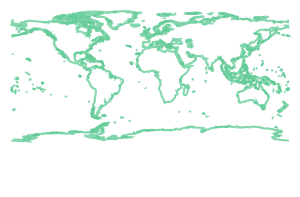

In [340]:
c #visualize

In [341]:
# lat/lon window
minlon = 100. 
maxlon =  165.
minlat = -50.
maxlat = -2.0004

In [342]:
#create a polygon of the grid
grp=geometry.Polygon([(minlon,minlat),(minlon,maxlat),(maxlon,maxlat),(maxlon,minlat)])

In [343]:
cl=[] #initialize
#add Polygons if they intersect with the grid
for i in range(len(c)):
    z = geometry.Polygon(c[i])
    if z.intersects(grp): 
            cl.append(c[i])

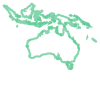

In [344]:
cll = geometry.MultiLineString(cl) #join them into a Multiline

cg = ops.linemerge(cll) #merge parts if possible

cg

In [345]:
lmin=1000
for line in cg:
    lmin=min([lmin, len(line.coords[:])])

In [346]:
lmin # minimum number of points per coastline component

6

In [22]:
#get all lines in a pandas DataFrame
if cg.type == 'LineString':
        lon=[]
        lat=[]
        for x,y in cg.coords[:]:
            lon.append(x)
            lat.append(y)
        dic= {'line0':{'lon':lon,'lat':lat}}
elif cg.type == 'MultiLineString' :
    dic={}
    for l in range(len(cg)):
        lon=[]
        lat=[]
        for x,y in cg[l].coords[:]:
            lon.append(x)
            lat.append(y)
        dic.update({'line{}'.format(l):{'lon':lon,'lat':lat}})

In [354]:
#get all lines in a pandas DataFrame
if cg.type == 'LineString':
        lon=[]
        lat=[]
        for f in np.linspace(0.,cg.length,1000):
            cp = cg.interpolate(f)
            lon.append(cp.x)
            lat.append(cp.y)
        dic= {'line0':{'lon':lon,'lat':lat}}
elif cg.type == 'MultiLineString' :
    dic={}
    for l in range(len(cg)):
        lon=[]
        lat=[]
        for f in np.linspace(0.,cg[l].length,1000):
            cp = cg[l].interpolate(f)
            lon.append(cp.x)
            lat.append(cp.y)

        dic.update({'line{}'.format(l):{'lon':lon,'lat':lat}})

In [355]:
dict_of_df = {k: pd.DataFrame(v) for k,v in dic.items()}
df = pd.concat(dict_of_df, axis=0)
df.head()

lat         lon
line0 0 -2.510254  100.011914
      1 -2.510724  100.011168
      2 -2.511194  100.010422
      3 -2.511664  100.009676
      4 -2.512134  100.008930

In [356]:
df['z']=0

<IPython.core.display.Javascript object>


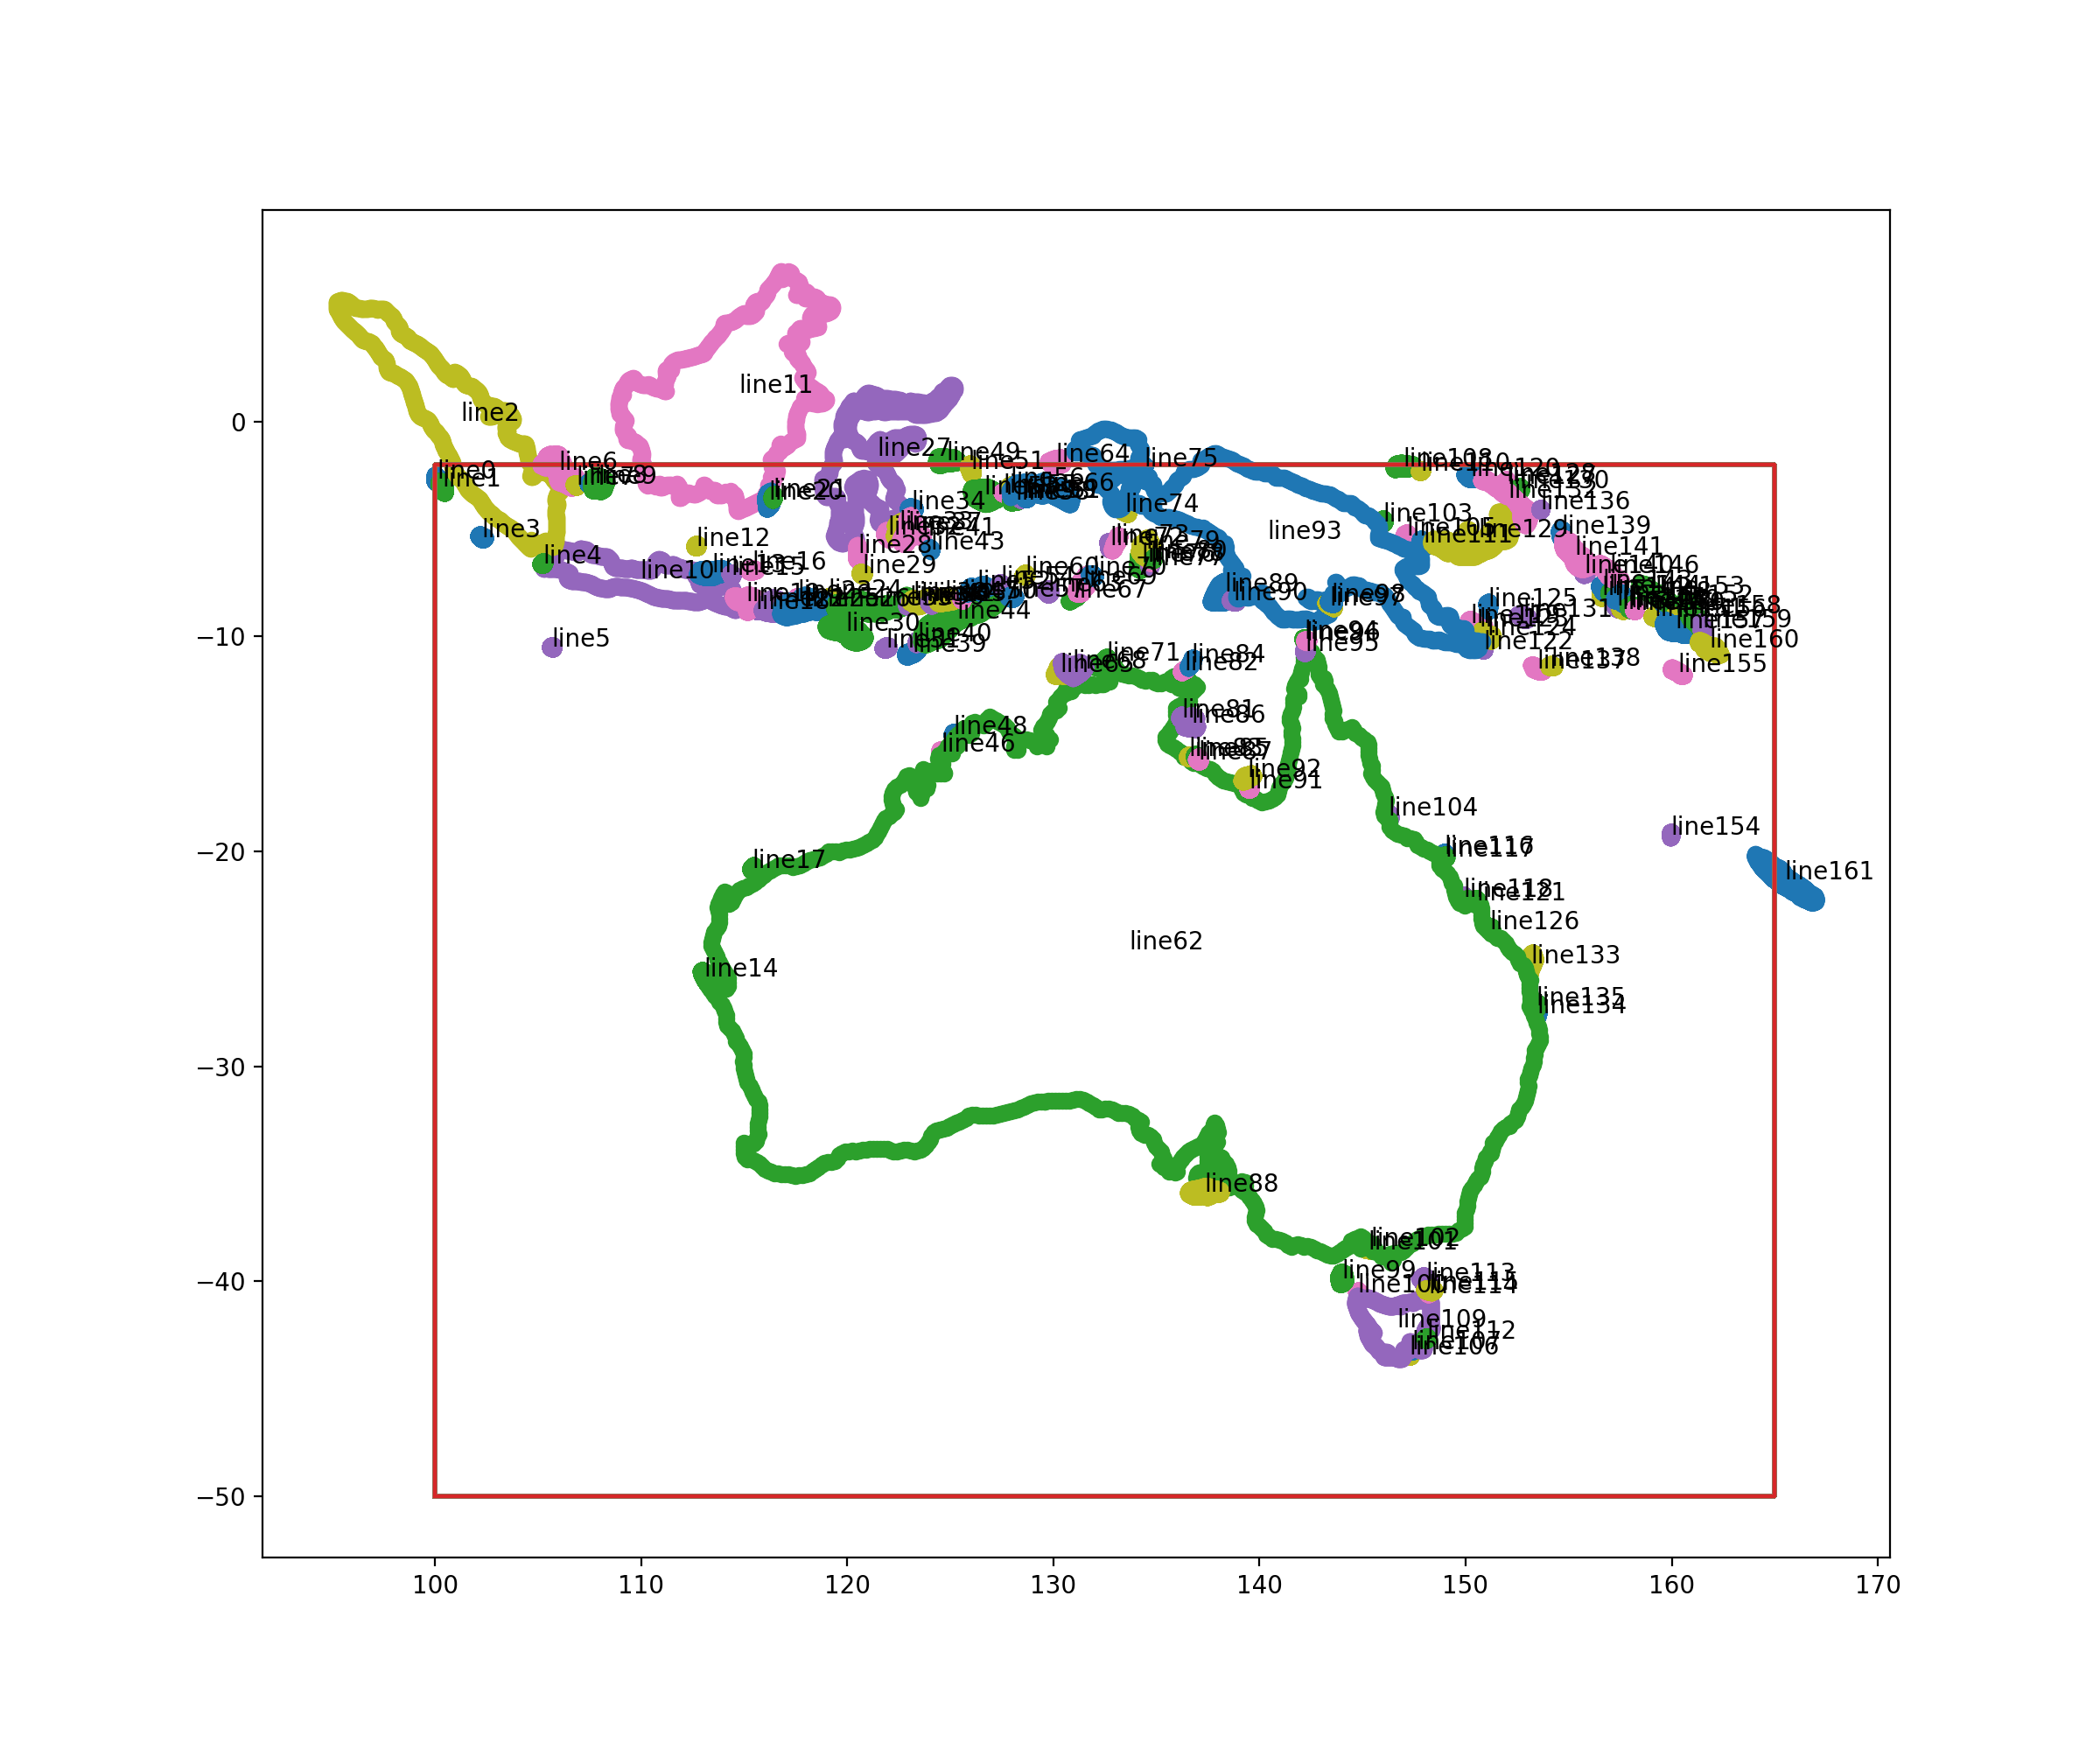

In [357]:
#plot xy points
plt.figure(figsize=(12,10))
#plt.scatter(df.loc[:,'lon'],df.loc[:,'lat'])
for line in df.index.levels[0]:
    xl = df.loc[line,'lon'].values
    yl = df.loc[line,'lat'].values
    plt.plot(xl,yl,'-o')
    axes = plt.gca()
    axes.annotate(line, xy=(xl.mean(), yl.mean()))#,xytext=(xl[k]+.01, yl[k]+.01),xycoords='data',size=12)
#    for k in range(xl.size):
#        axes.annotate(k, xy=(xl[k], yl[k]),xytext=(xl[k]+.01, yl[k]+.01),xycoords='data',size=12)
#    axes.set_xlim([df.lon.min(),df.lon.max()])
#    axes.set_ylim([df.lat.min(),df.lat.max()])
    plt.plot([minlon,minlon,maxlon,maxlon,minlon],[minlat,maxlat,maxlat,minlat,minlat])

## GEO.msh file 

### Computing the enclosing boundary

In [358]:
bp = shapely.geometry.Polygon([[minlon,minlat],[maxlon,minlat],[maxlon,maxlat],[minlon,maxlat]])

In [359]:
bb = shapely.geometry.LinearRing([[minlon,minlat],[maxlon,minlat],[maxlon,maxlat],[minlon,maxlat]])

In [360]:
w = cg.intersection(bp)

In [361]:
len(cg)

162

In [362]:
#store the index of the totally enclosed LineStrings
ins=[]
for i in range(len(cg)):
#    if cg[i].intersects(bb): print i
    if bp.contains(cg[i]): ins.append(i)

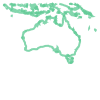

In [363]:
w

In [364]:
q = cg.difference(bp)

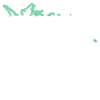

In [365]:
q

In [366]:
#save the intersections and the linestrings of the intersected elements
s=[]
si=[]
for i in range(len(w)):
    if w[i].is_ring : continue
    inter = np.array(w[i].intersection(bb))
    if inter.size == 4:
        print i
        si.append( inter )
        s.append(np.array(w[i]))

cr = np.vstack(si)

3
13
29
51
67
97
114
168


In [367]:
cr

array([[100.8529921 ,  -2.0004    ],
       [104.70457947,  -2.0004    ],
       [110.09620237,  -2.0004    ],
       [116.43498607,  -2.0004    ],
       [119.26527772,  -2.0004    ],
       [121.44569877,  -2.0004    ],
       [124.41489777,  -2.0004    ],
       [124.54758432,  -2.0004    ],
       [129.95551503,  -2.0004    ],
       [130.30203421,  -2.0004    ],
       [134.14467915,  -2.0004    ],
       [137.17334046,  -2.0004    ],
       [146.61911853,  -2.0004    ],
       [147.43122721,  -2.0004    ],
       [165.        , -21.32231094],
       [165.        , -20.69238491]])

In [368]:
len(si), len(s)

(8, 8)

In [369]:
# make them all anti-clockwise
#for k in range(len(s)):
#    su=0.
#    for i, j in zip(s[k], s[k][1:]):
#        su = su + (i[0] + j[0]) * (i[1] - j[1])
#    print su 
#    if su > 0 : s[k]=s[k][::-1]
        

In [370]:
c = [[minlon,minlat],[minlon,minlat]] # initialize lower left corner

In [371]:
# left boundary
for i in range(0,cr.shape[0],2):
    if cr[i,0] == c[-1][0]:
        k = i/2
        if s[k][-1][1] < s[k][0][1] : s[k]=s[k][::-1]
        c = np.vstack([c,s[k]])

In [372]:
c = np.vstack([c,[minlon,maxlat]]) # add upper left corner

In [373]:
#upper boundary
for i in range(0,cr.shape[0],2):
    if cr[i,1] == c[-1][1]:
        k = i/2
        if s[k][-1][0] < s[k][0][0] : s[k]=s[k][::-1]
        c = np.vstack([c,s[k]])

In [374]:
c = np.vstack([c,[maxlon,maxlat]]) # add upper right corner

In [375]:
#right boundary
for i in range(0,cr.shape[0],2):
    if cr[i,0] == c[-1][0]:
        k = i/2
        if s[k][-1][1] > s[k][0][1] : s[k]=s[k][::-1]
        c = np.vstack([c,s[k]])

In [376]:
c = np.vstack([c,[maxlon,minlat]]) # add low right corner

In [377]:
#lower boundary
for i in range(cr.shape[0]):
    if cr[i,1] == c[-1][1]:
        k = i/2
        if s[k][-1][0] > s[k][0][0] : s[k]=s[k][::-1]            
        c = np.vstack([c,s[i]])

In [378]:
c = np.vstack([c[1:],c[0]]) #wrap around

In [379]:
c.shape

(440, 2)

<IPython.core.display.Javascript object>


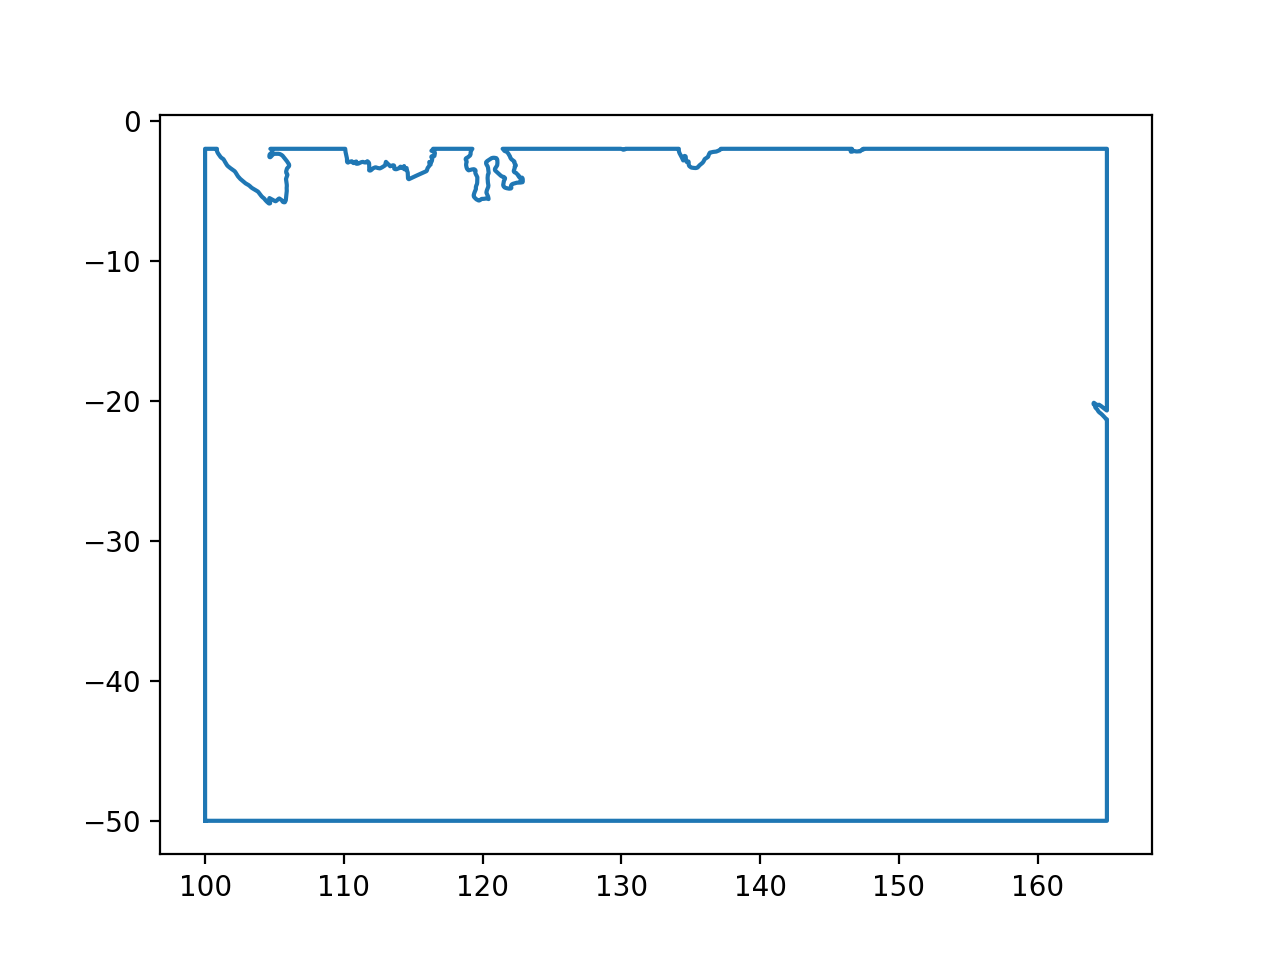

In [380]:
plt.figure()
plt.plot(c[:,0],c[:,1])
plt.show()

In [49]:
lc = shapely.geometry.LineString(c)

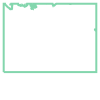

In [381]:
lc

In [382]:
lc.length

259.79361328516245

In [383]:
xy = []
for f in np.linspace(0.,lc.length,1000):
    cp = lc.interpolate(f)
    xy.append([cp.x, cp.y])

In [384]:
xy = np.array(xy)

<IPython.core.display.Javascript object>


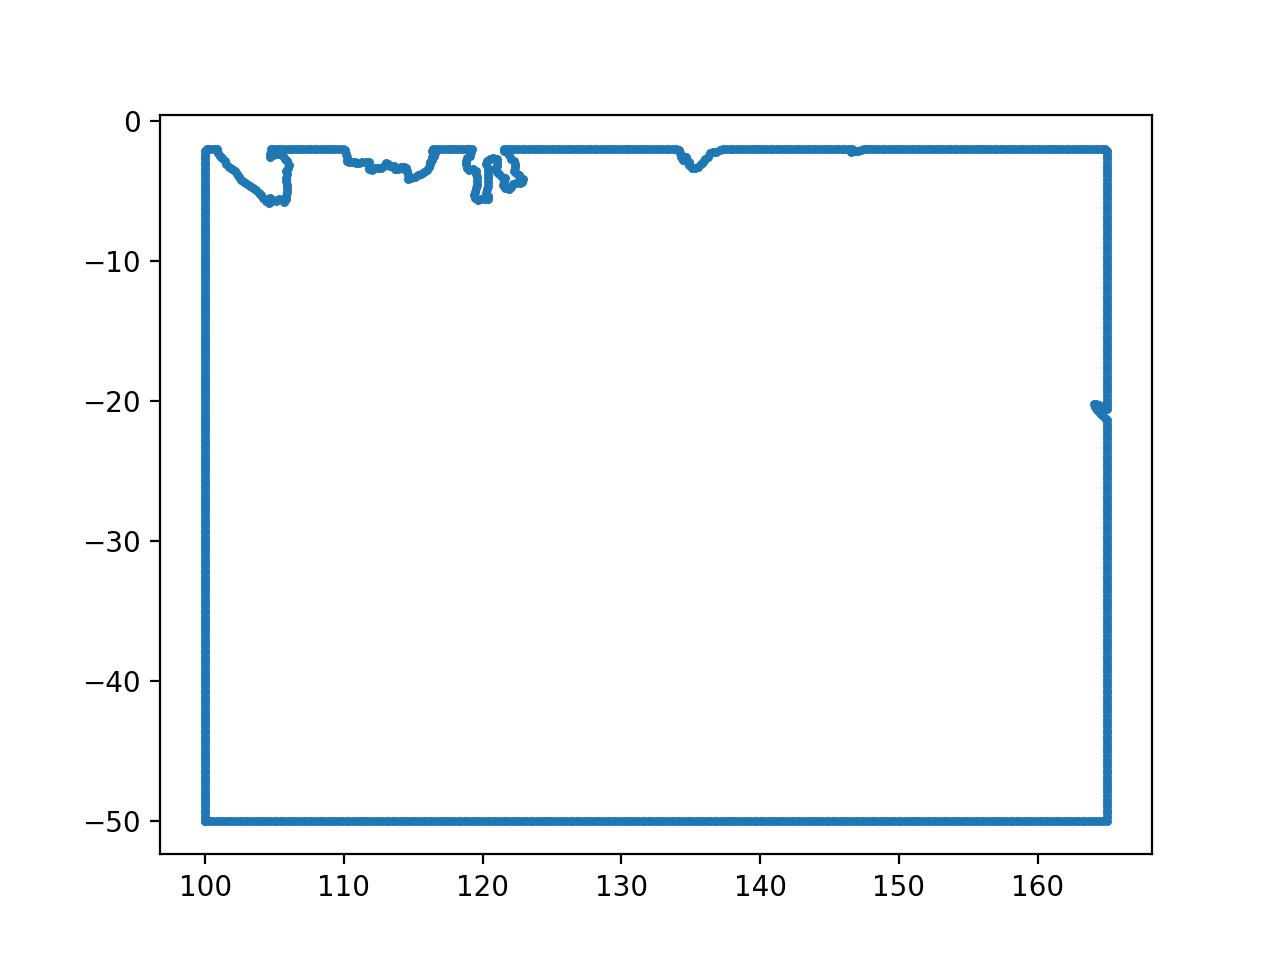

In [385]:
plt.figure()
plt.scatter(xy[:,0],xy[:,1], s=5)
plt.show()

In [55]:
box = pd.DataFrame(xy,columns=['lon','lat'])

In [386]:
box['z'] = 0

In [387]:
box.head()

lon        lat  z
0  100.0 -50.000000  0
1  100.0 -49.739946  0
2  100.0 -49.479893  0
3  100.0 -49.219839  0
4  100.0 -48.959785  0

In [388]:
con = pd.concat([box], keys=['box'])

In [389]:
con.head()

lon        lat  z
box 0  100.0 -50.000000  0
    1  100.0 -49.739946  0
    2  100.0 -49.479893  0
    3  100.0 -49.219839  0
    4  100.0 -48.959785  0

In [390]:
con = con.append(df.loc[['line{}'.format(i) for i in ins]])

In [391]:
fgeo='/Users/brey/Downloads/JIGSAW/geo/AUS-GEOM.msh'

In [392]:
#drop last line if it wraps around
for line in con.index.levels[0]:
    if (con.loc[(line,con.loc[line].shape[0]-1)] == con.loc[(line,0)]).all() :
        con = con.drop((line,con.loc[line].shape[0]-1))

<IPython.core.display.Javascript object>


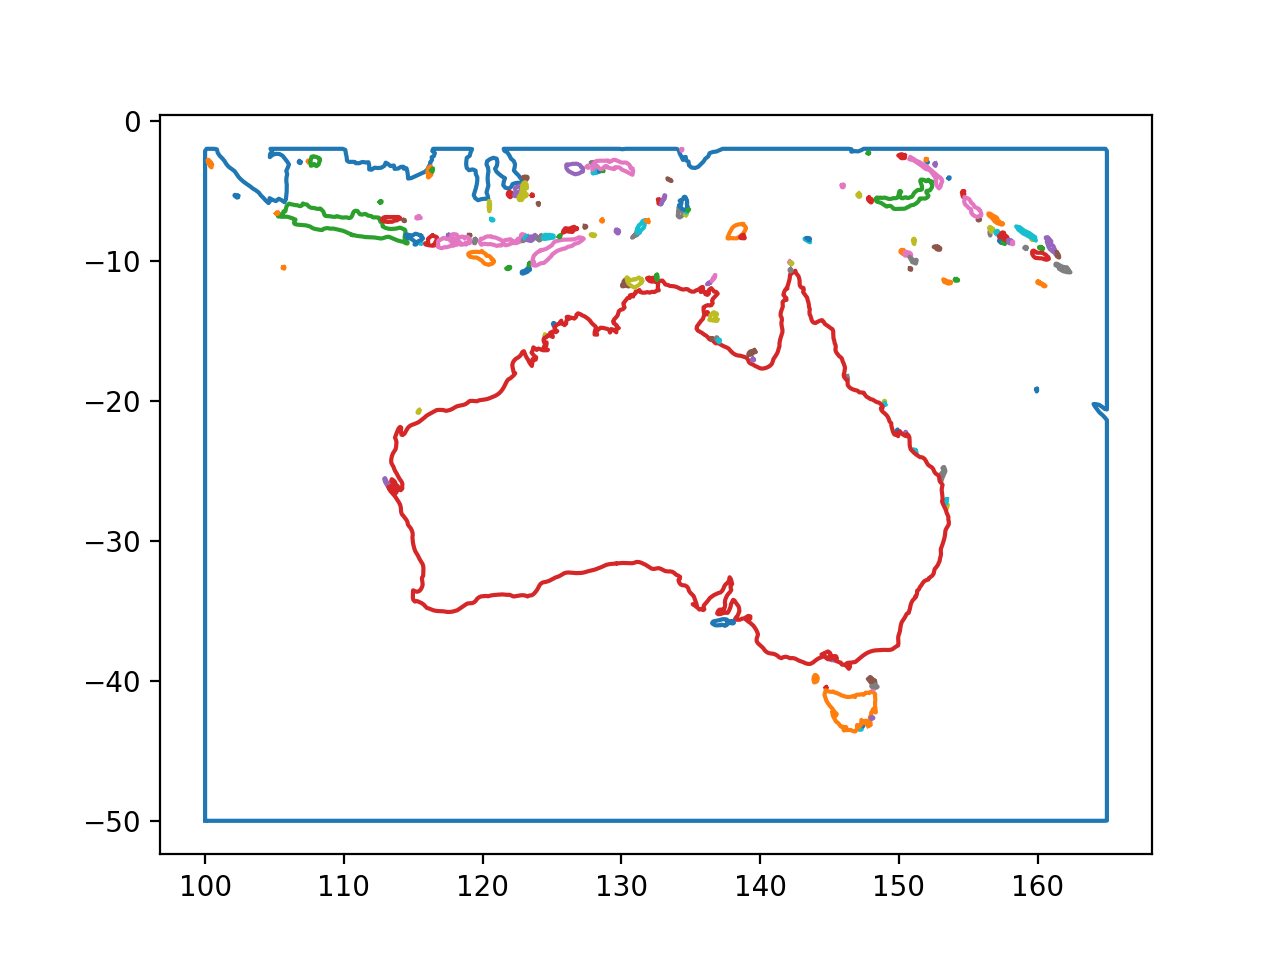

In [393]:
plt.figure()
for line in con.index.levels[0]:
    x, y = con.loc[line,['lon']].values, con.loc[line,['lat']].values
    plt.plot(x,y)
    
    

In [394]:
# write header
with open(fgeo,'w') as f:
    f.write('#{}; created by pyPoseidon\n'.format(fgeo.split('/')[-1]))
    f.write('MSHID=2;EUCLIDEAN-MESH\n')
    f.write('NDIMS=2\n')
    f.write('POINT={}\n'.format(con.shape[0]))    # plus 4 for box


In [395]:
#write lines
with open(fgeo, 'a') as f:
    for line in con.index.levels[0]:
        con.loc[line].to_csv(f, index=False, header=0, columns=['lon','lat','z'],sep=';')

In [396]:
edges = pd.DataFrame([]) # initiate

# create edges
for line in con.index.levels[0]:
    i0 = edges.shape[0]
    ie = con.loc[line].shape[0]+edges.shape[0]
    edges = edges.append(pd.DataFrame([[i,i + 1,0] for i in range(i0,ie)]))
    edges.iloc[-1][1]=i0

In [397]:
# write header
with open(fgeo,'a') as f:
    f.write('EDGE2={}\n'.format(edges.shape[0]))

In [398]:
with open(fgeo, 'a') as f:
    edges.to_csv(f, index=False, header=0, sep=';')

## hfun file

### read bathymetry file

In [399]:
fbath = '/Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/geo/topo.msh'

In [400]:
coord, nc = pd.read_csv(fbath,header=2,skiprows=1,nrows=0,delimiter='=')
coord, nc

('COORD', '1;1201')

In [401]:
nc0, nc1 = nc.split(';')
nc1 = int(nc1)

In [402]:
#read lon for all boundary nodes
xb = pd.read_csv(fbath,skiprows=4,header=None,nrows=nc1,names=['x'])

In [403]:
coord, nc = pd.read_csv(fbath,header=4,skiprows=nc1,nrows=0,delimiter='=')
coord, nc

('COORD', '2;601')

In [404]:
nc0, nc2 = nc.split(';')
nc2 = int(nc2)

In [405]:
#read lat,depth for boundary nodes
yb = pd.read_csv(fbath,skiprows=5 + nc1,header=None,nrows=nc2,names=['y'])

In [406]:
value, nc = pd.read_csv(fbath,header=4,skiprows=nc1+nc2+1,nrows=0,delimiter='=')
value, nc

('VALUE', '721801;1')

In [407]:
val, val0 = nc.split(';')
val = int(val)

In [408]:
#read 
bath = pd.read_csv(fbath,skiprows=6 + nc1 + nc2,header=None,nrows=val,names=['value'])

In [409]:
bath.head()

value
0   2773
1   2806
2   2911
3   2993
4   3062

In [410]:
bath.tail()

value
721796   -997
721797  -2408
721798  -3649
721799  -4139
721800  -4120

In [411]:
vb = bath.values.reshape(nc1,nc2)

In [412]:
vb.shape

(1201, 601)

In [413]:
vb=vb.T

In [414]:
vb.min(), vb.max()

(-10188, 7016)

In [415]:
X, Y = np.meshgrid(xb,yb)

<IPython.core.display.Javascript object>


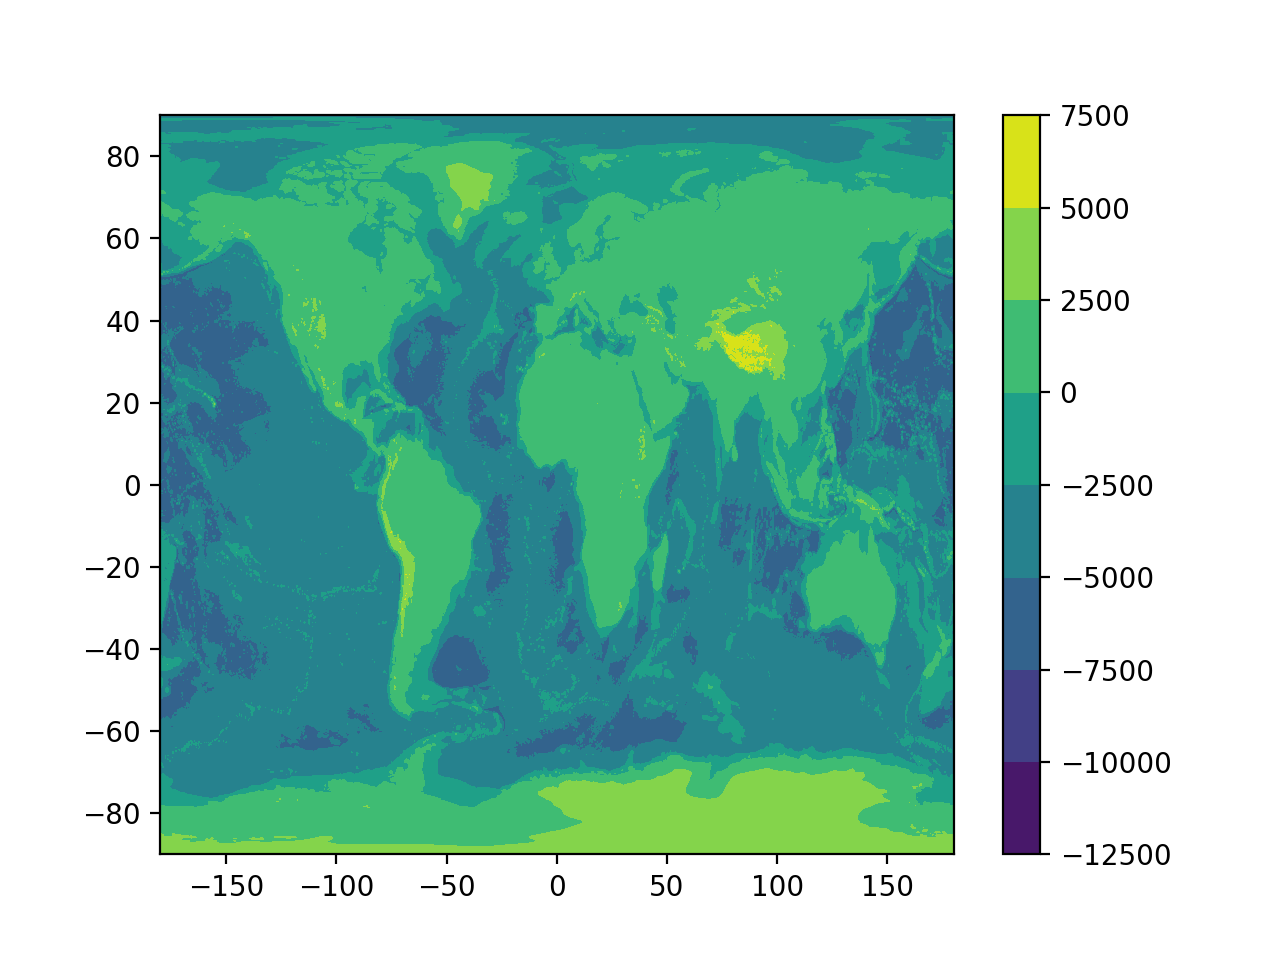

In [416]:
### plot
plt.figure()
plt.contourf(X,Y,vb)
plt.colorbar()

In [87]:
# select relevant window
i1=np.abs(xb.values-minlon).argmin()
if i1 > 0: i1=i1-1
i2=np.abs(xb.values-maxlon).argmin()
if i2 < xb.shape[0] : i2=i2+1
i1,i2

(932, 1151)

In [417]:
# select relevant window
j1=np.abs(yb.values-minlat).argmin()
if j1 > 0: j1=j1-1
j2=np.abs(yb.values-maxlat).argmin()
if j2 < yb.shape[0] : j2=j2+1
j1,j2

(132, 294)

In [418]:
X, Y = np.meshgrid(xb[i1:i2],yb[j1:j2])

In [419]:
X.min(), X.max()

(99.599998, 165.0)

In [420]:
Y.min(), Y.max()

(-50.400002, -2.0999999)

In [421]:
V = vb[j1:j2,i1:i2]

In [422]:
V.min(), V.max()

(-8219, 3657)

In [423]:
V

array([[-3545, -3655, -3548, ..., -3590, -3721, -3617],
       [-3620, -3602, -3426, ..., -2949, -3647, -3606],
       [-3380, -3431, -3522, ..., -3222, -3483, -3743],
       ...,
       [-2136,  -193,   -26, ..., -4449, -4448, -3402],
       [ -390,  -117, -1179, ..., -4083, -4298, -3498],
       [  127, -1416, -1720, ..., -4240, -4379, -4412]])

<IPython.core.display.Javascript object>


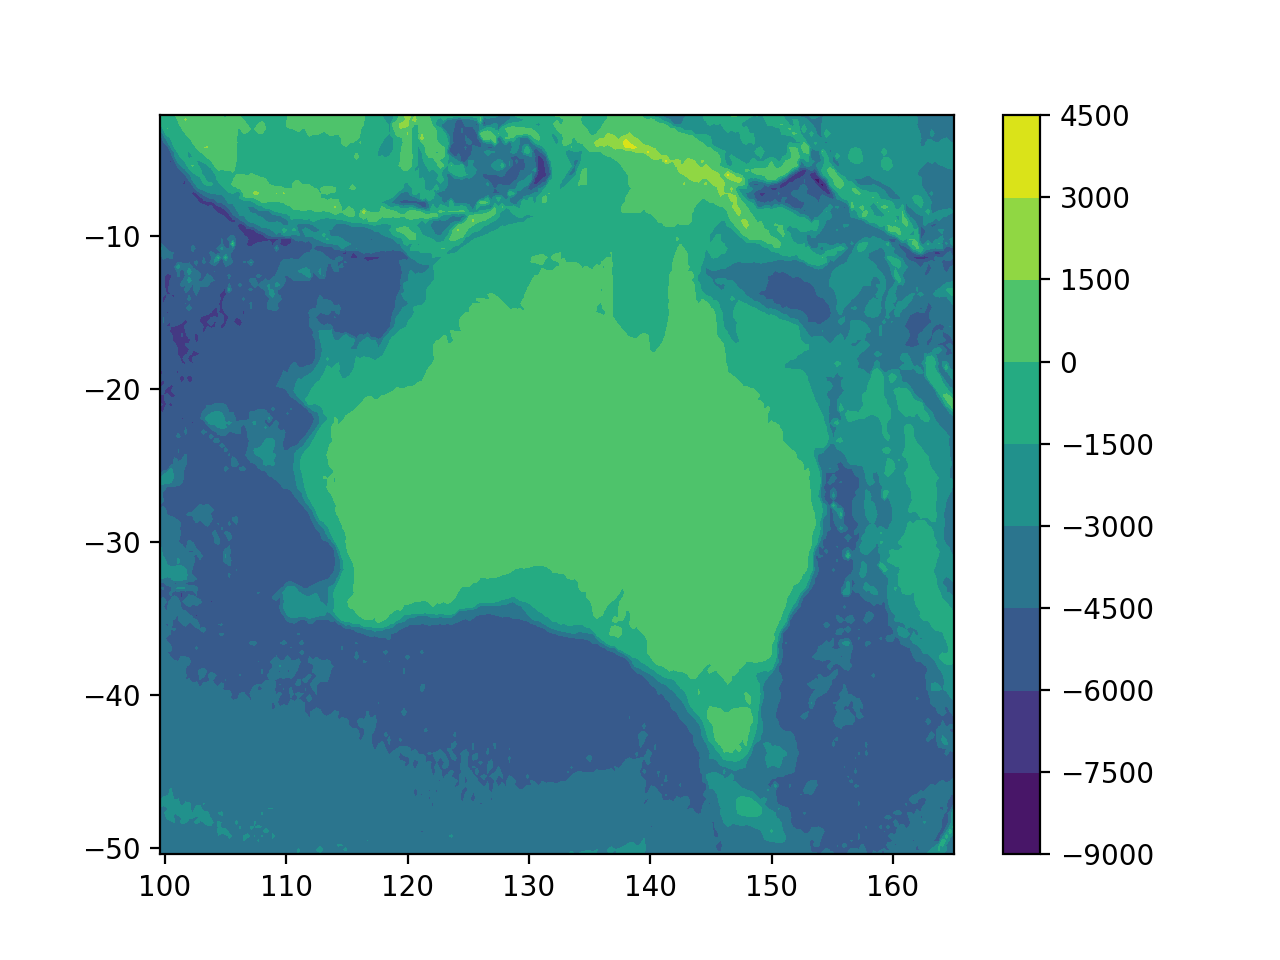

In [424]:
### plot
plt.figure()
plt.contourf(X,Y,V)
plt.colorbar()

### Scale

In [425]:
eps = np.finfo(float).eps

In [426]:
hmin = +.025                       # min. H(X) [deg.]
hmax = +.750                       # max. H(X)

V[V>0] = eps #normalize to only negative values

hfun =  np.sqrt(-V)/75. # scale with sqrt(H)
hfun[hfun < hmin] = hmin
hfun[hfun > hmax] = hmax

In [427]:
hfun = hfun.flatten() # make it 1-d

In [428]:
hfun = np.array([[hf] for hf in list(hfun)]) #convert it to the appropriate format for LIMHFN2 below

In [429]:
hfun.min(), hfun.max(), hfun.mean()

(0.025, 0.75, 0.4645601911368183)

<IPython.core.display.Javascript object>


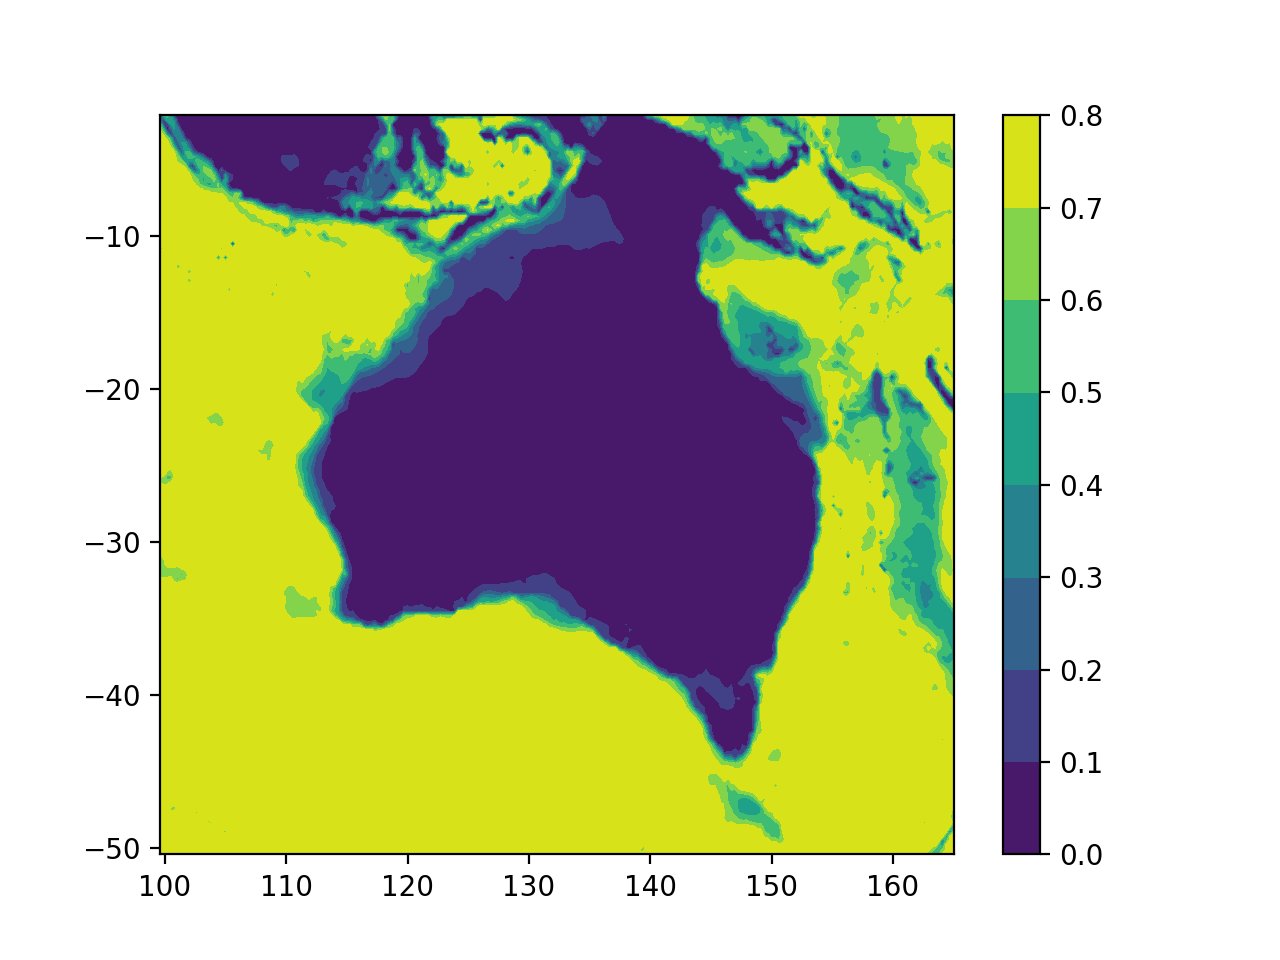

In [430]:
#plot
plt.figure()
plt.contourf(X,Y,hfun.reshape(X.shape))
plt.colorbar()

### triangulate

In [431]:
points = np.column_stack([X.flatten(),Y.flatten()])

In [432]:
#scipy option
# https://stackoverflow.com/questions/36604172/difference-between-matlab-delaunayn-and-scipy-delaunay
#options = 'Qt Qbb Qc'
#dela = scipy.spatial.Delaunay(points, qhull_options = options)
#tri = dela.simplices

#N=2
#keep = np.ones(len(tri), dtype = bool)
#for i, t in enumerate(tri):
#    if abs(np.linalg.det(np.hstack((points[t], np.ones([1,N+1]).T)))) < 1.E-15:
#        keep[i] = False # Point is coplanar, we don't want to keep it
#tri = tri[keep]

#tri

In [433]:
# Use Matplotlib for triangulation
triang = matplotlib.tri.Triangulation(points[:,0], points[:,1])

In [434]:
tri = triang.triangles

In [435]:
edges = triang.edges

In [436]:
edges.shape

(105673, 2)

In [437]:
#edge lengths
elen = [shapely.geometry.LineString(points[edge]).length for edge in edges]

In [438]:
min(elen), max(elen), np.mean(elen)

(0.299980000000005, 0.424273968228079, 0.3412728097093577)

In [439]:
#plot grid
#plt.figure(figsize=(12,10))
#plt.triplot(triang, 'bo-', lw=1)
#plt.show()

### LIMGRAD impose gradient limits on a discrete mesh-size function defined over a 2-simplex triangulation (from JIGSAW tools)

In [440]:
dhdx = +.150                       # smoothing limits

In [441]:
def limgrad(edge,elen,ffun,dfdx,imax):
    
    rfun = ffun.copy()
    
    eps = np.finfo(float).eps
    
    nnod = rfun.size
    
    #-- IVEC(NPTR(II,1):NPTR(II,2)) are edges adj. to II-TH node
    nvec = np.hstack([edge[:,0], edge[:,1]])
    ivec = np.hstack([np.arange(edge.shape[0]),np.arange(edge.shape[0])])

    nvec_ = np.sort(nvec)
    pidx = np.argsort(nvec, kind='mergesort') # to match with matlab/octave -> https://stackoverflow.com/questions/39484073/matlab-sort-vs-numpy-argsort-how-to-match-results
    ivec = ivec[pidx]
    nvec = nvec_
    
    mark = np.full(len(rfun), False, dtype=bool)
    mark[edge[:,0]]=True
    mark[edge[:,1]]=True
    
    dif = [nvec[i+1]-nvec[i] for i in range(nvec.shape[0]-1)]
    
    idxx = np.argwhere(np.array(dif) > 0).flatten()
    
    nptr = np.zeros((nnod,2))
    nptr[:,1] = -1 
    nptr[mark,0] = np.append(np.array([0]),idxx+1)
    nptr[mark,1] = np.append(idxx, nnod)
    
    nptr = nptr.astype(int)
#----------------------------- ASET=ITER if node is "active"
    aset = np.zeros(len(rfun))
    
#----------------------------- exhaustive 'til all satisfied 
    ftol = min(rfun) * np.sqrt(eps)
    
    for i in range(1,imax):
    
    #------------------------- find "active" nodes this pass
        aidx = np.argwhere(aset == i - 1 ) 
        aidx = aidx.flatten()
        
        if not aidx.any(): break
      
    #------------------------- reorder => better convergence
        aval = np.sort(rfun[aidx].flatten())
        idxx = np.argsort(rfun[aidx].flatten(), kind='mergesort')
        aidx = aidx[idxx]
       
    #%------------------------- visit adj. edges and set DFDX
        for ipos in range(len(aidx)):
            npos = aidx[ipos]
        
            for jpos in range(nptr[npos,0], nptr[npos,1]+1):
                
                epos = ivec[jpos]
                
                nod1 = edge[epos,0]
                nod2 = edge[epos,1]

            #----------------- calc. limits about min.-value
                if rfun[nod1] > rfun[nod2]:
                
                    
                    fun1 = rfun[nod2] + elen[epos] * dfdx 
                
                    if rfun[nod1] > fun1+ftol :
                        rfun[nod1] = fun1
                        aset[nod1] = i
                else:
                
                    fun2 = rfun[nod1] + elen[epos] * dfdx 
                    
                    if   rfun[nod2] > fun2+ftol :
                        rfun[nod2] = fun2
                        aset[nod2] = i
     
    flag = i < imax
    
    return rfun,flag

In [442]:
def limgrad2(edge,elen,ffun,dfdx,imax):
    
    rfun = ffun.T.flatten()
    
    rfun = np.array([[hf] for hf in list(rfun)])
    
    eps = np.finfo(float).eps
    
    nnod = rfun.size
        
    #-- IVEC(NPTR(II,1):NPTR(II,2)) are edges adj. to II-TH node
    nvec = np.hstack([edge[:,0], edge[:,1]])

    ivec = np.hstack([np.arange(edge.shape[0]),np.arange(edge.shape[0])])


    nvec_ = np.sort(nvec, kind='mergesort')
    pidx = np.argsort(nvec, kind='mergesort') # to match with matlab/octave -> https://stackoverflow.com/questions/39484073/matlab-sort-vs-numpy-argsort-how-to-match-results
    ivec = ivec[pidx]
    nvec = nvec_
    
    
    mark = np.full(rfun.size, False, dtype=bool)
    mark[edge[:,0]]=True
    mark[edge[:,1]]=True

    dif = [nvec[i+1]-nvec[i] for i in range(nvec.shape[0]-1)]
    idxx = np.argwhere(np.array(dif) > 0).flatten()
    
    nptr=np.zeros((mark.size,2))
    nptr[mark,0] = np.append(np.array([0]),idxx+1)
    nptr[mark,1] = np.append(idxx, nnod-1)
    
    nptr = nptr.astype(int)

#----------------------------- ASET=ITER if node is "active"
    aset = np.zeros(nnod)
    
    ftol = min(rfun.flatten()) * np.sqrt(eps)
    

#----------------------------- exhaustive 'til all satisfied 
    
    for i in range(1,imax):
    
    #------------------------- find "active" nodes this pass
        aidx = np.argwhere(aset == i - 1 ) 
        aidx = aidx.flatten()
        
        if not aidx.any(): break
      
    #------------------------- reorder => better convergence

        aval = np.sort(rfun.reshape(ffun.shape).flatten()[aidx],kind='mergesort')
        idxx = np.argsort(rfun.reshape(ffun.shape).flatten()[aidx], kind='mergesort')
        
        aidx = aidx[idxx]
       
    #%------------------------- visit adj. edges and set DFDX
        for ipos in range(len(aidx)):
            npos = aidx[ipos]
        
            for jpos in range(nptr[npos,0], nptr[npos,1]+1):
                
                epos = ivec[jpos]
                
                nod1 = edge[epos,0]
                nod2 = edge[epos,1]
                
               # print ipos, jpos, epos, nod1, nod2

            #----------------- calc. limits about min.-value
                if rfun[nod1] > rfun[nod2]:
                
                    
                    fun1 = rfun[nod2] + elen[epos] * dfdx 
                
                    if rfun[nod1] > fun1+ftol :
                        rfun[nod1] = fun1
                        aset[nod1] = i
                else:
                
                    fun2 = rfun[nod1] + elen[epos] * dfdx 
                    
                    if   rfun[nod2] > fun2+ftol :
                        rfun[nod2] = fun2
                        aset[nod2] = i
     
    flag = i < imax
    
    return rfun,flag

In [443]:
#edge2 = pd.read_csv('/Users/brey/Desktop/edge',header=None).values

#edge2 = edge2 - 1

#elen2 = pd.read_csv('/Users/brey/Desktop/elen',header=None).values

#hfun2 = pd.read_csv('/Users/brey/Desktop/hfun0',header=None).values

#rfun2 = pd.read_csv('/Users/brey/Desktop/fun',header=None).values


#run it
#[rfun,flag] = limgrad(edge2,elen2,hfun2,dhdx,100)

#difference from the original hfun2
#dff = rfun.flatten().reshape(X.T.shape).T - hfun2.flatten().reshape(X.T.shape).T # note the transpose 

In [444]:
[fun,flag] = limgrad(edges,elen,hfun,dhdx,100)

In [445]:
[fun2,flag] = limgrad2(edges,elen,hfun,dhdx,100)

In [117]:
#difference from the original hfun
dff = fun2.flatten().reshape(X.shape) - hfun.flatten().reshape(X.shape)

In [118]:
#difference between solutions (JIGSAW & This one)
#dff = fun.flatten().reshape(X.shape) - rfun.flatten().reshape(X.T.shape).T

In [119]:
dff.min(), dff.max(), dff.mean()

(-0.6800029999999992, 0.0, -0.10199660137608571)

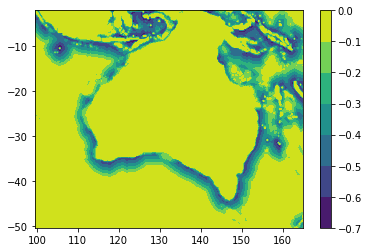

In [120]:
#plot
plt.figure()
plt.contourf(X,Y,dff)
plt.colorbar()

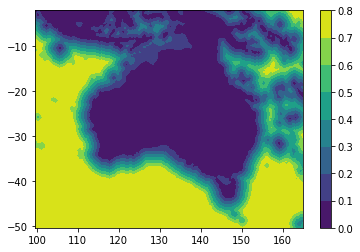

In [124]:
#plot
plt.figure()
plt.contourf(X,Y,fun.flatten().reshape(X.shape))
plt.colorbar()

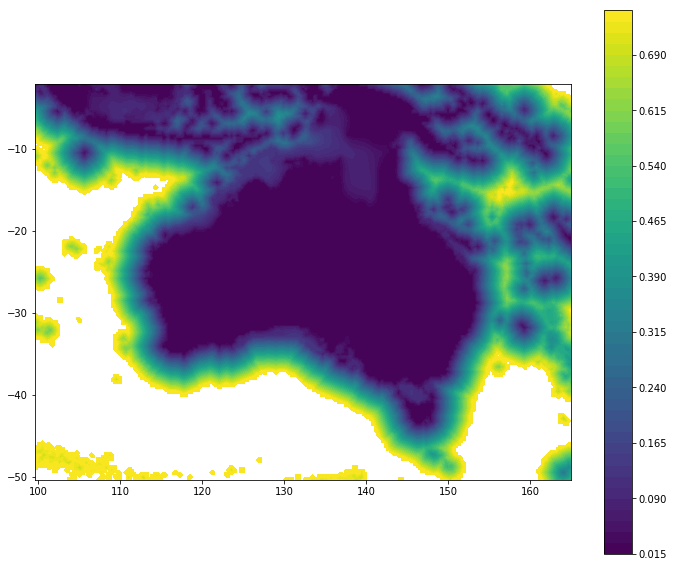

In [125]:
#plot
plt.figure(figsize=(12,10))
plt.gca().set_aspect('equal')
plt.tricontourf(triang, fun.flatten(), 50 )
plt.colorbar()
plt.show()

In [446]:
ffun='/Users/brey/Downloads/JIGSAW/out/AUS-HFUN.msh'

In [447]:
# write header
with open(ffun,'w') as f:
    f.write('#{}; created by pyPoseidon\n'.format(ffun.split('/')[-1]))
    f.write('MSHID=3;EUCLIDEAN-GRID\n')
    f.write('NDIMS=2\n')
    f.write('COORD=1;{}\n'.format(xb[i1:i2].size))

In [448]:
with open(ffun, 'a') as f:
    xb[i1:i2].to_csv(f, index=False, header=0)

In [449]:
with open(ffun, 'a') as f:
    f.write('COORD=2;{}\n'.format(yb[j1:j2].size))

In [450]:
with open(ffun, 'a') as f:
    yb[j1:j2].to_csv(f, index=False, header=0)

In [451]:
with open(ffun, 'a') as f:
    f.write('VALUE={};1\n'.format(xb[i1:i2].size * yb[j1:j2].size)) 

In [452]:
#with open(ffun, 'a') as f:
#    for i in range(fun.size):
#        f.write('{}\n'.format(fun.flatten()[i]))

In [453]:
#converted TRANSPOSED, IS THERE A WAY TO FIX IT?
cfun = fun.flatten().reshape(X.shape).T
with open(ffun, 'a') as f:
    for i in range(fun.size):
        f.write('{}\n'.format(cfun.flatten()[i]))

### test hfun file

In [454]:
#ffun = '/Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/out/AUS-HFUN.msh'

In [455]:
coord, nc = pd.read_csv(ffun,header=2,skiprows=1,nrows=0,delimiter='=')
coord, nc

('COORD', '1;219')

In [456]:
nc0, nc1 = nc.split(';')
nc1 = int(nc1)

In [457]:
#read lon for all boundary nodes
xf = pd.read_csv(ffun,skiprows=4,header=None,nrows=nc1,names=['x'])

In [458]:
coord, nc = pd.read_csv(ffun,header=4,skiprows=nc1,nrows=0,delimiter='=')
coord, nc

('COORD', '2;162')

In [459]:
nc0, nc2 = nc.split(';')
nc2 = int(nc2)

In [460]:
#read lat,depth for boundary nodes
yf = pd.read_csv(ffun,skiprows=5 + nc1,header=None,nrows=nc2,names=['y'])

In [461]:
value, nc = pd.read_csv(ffun,header=4,skiprows=nc1+nc2+1,nrows=0,delimiter='=')
value, nc

('VALUE', '35478;1')

In [462]:
val, val0 = nc.split(';')
val = int(val)

In [463]:
#read 
vs = pd.read_csv(ffun,skiprows=6 + nc1 + nc2,header=None,nrows=val,names=['value'])

In [464]:
X, Y = np.meshgrid(xf,yf)

In [465]:
V = vs.values.reshape(nc1,nc2) #NOTE THE TRANSPOSE

#### plot

<IPython.core.display.Javascript object>


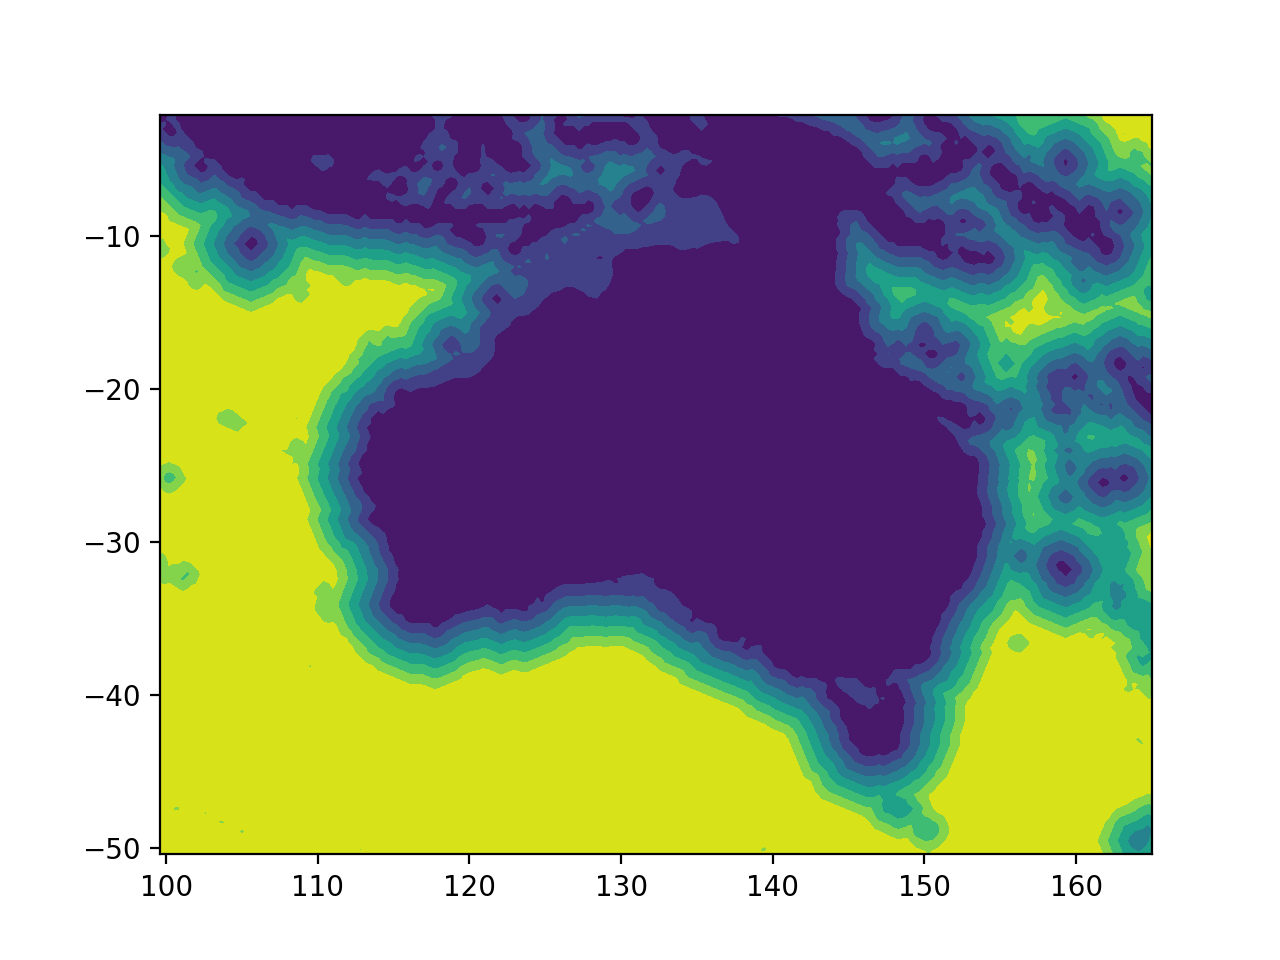

In [466]:
plt.figure()
plt.contourf(X,Y,V.T)


## jig file

In [467]:
jig='/Users/brey/Downloads/JIGSAW/AUS.jig'

In [468]:
fmsh = '/Users/brey/Downloads/JIGSAW/out/AUS.msh'

In [469]:
with open(jig,'w') as f:
    f.write('GEOM_FILE ={}\n'.format(fgeo))
    f.write('MESH_FILE ={}\n'.format(fmsh))
    f.write('HFUN_FILE ={}\n'.format(ffun))
    f.write('HFUN_SCAL = ABSOLUTE\n')
    f.write('HFUN_HMAX = Inf\n')
    f.write('HFUN_HMIN = 0.0\n')
    f.write('MESH_DIMS = 2\n')
#    f.write('MESH_TOP1 = TRUE\n')
    f.write('MESH_EPS1 = 1.0\n')
    f.write('MESH_RAD2=1\n')
    f.write('VERBOSITY = 2')

## Cross check / Verify

### Nodes

In [470]:
#fgeo = '/Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/geo/AUS-GEOM.msh'

In [471]:
#extract number of elements, number of nodes
point,nn=pd.read_csv(fgeo,header=2,skiprows=1,nrows=0,delimiter='=')
point, nn

('POINT', '151848')

In [472]:
nn=int(nn)

In [473]:
#read lon,lat,depth for all nodes
xy=pd.read_csv(fgeo,skiprows=4,header=None,delimiter=';',engine='python',nrows=nn,names=['x','y','z'])

In [474]:
xy.shape

(151848, 3)

In [475]:
xy.head()

x          y  z
0  100.0 -50.000000  0
1  100.0 -49.739946  0
2  100.0 -49.479893  0
3  100.0 -49.219839  0
4  100.0 -48.959785  0

In [476]:
xy.tail()

x          y  z
151843  144.119747 -39.792141  0
151844  144.119977 -39.790764  0
151845  144.120207 -39.789386  0
151846  144.120438 -39.788009  0
151847  144.120668 -39.786631  0

### Edges

In [477]:
edge2,ne=pd.read_csv(fgeo,header=4,skiprows=nn,nrows=0,delimiter='=')

In [478]:
ne = int(ne)

In [479]:
ne

151848

In [480]:
e2=pd.read_csv(fgeo,skiprows=nn+5,header=None,delimiter=';',engine='python',nrows=ne,names=['a','b','c'])

In [481]:
e2.head()

a  b  c
0  0  1  0
1  1  2  0
2  2  3  0
3  3  4  0
4  4  5  0

In [482]:
e2.tail()

a       b  c
151843  151843  151844  0
151844  151844  151845  0
151845  151845  151846  0
151846  151846  151847  0
151847  151847  150849  0

### Visualize

In [483]:
#get edge lon/lat
elon=[]
elat=[]
for index, row in e2.loc[:,['a','b']].iterrows():
    i, j = row['a'], row['b']
    elon.append(xy.x[i])
    elat.append(xy.y[i])
    elon.append(xy.x[j])
    elat.append(xy.y[j])


<IPython.core.display.Javascript object>


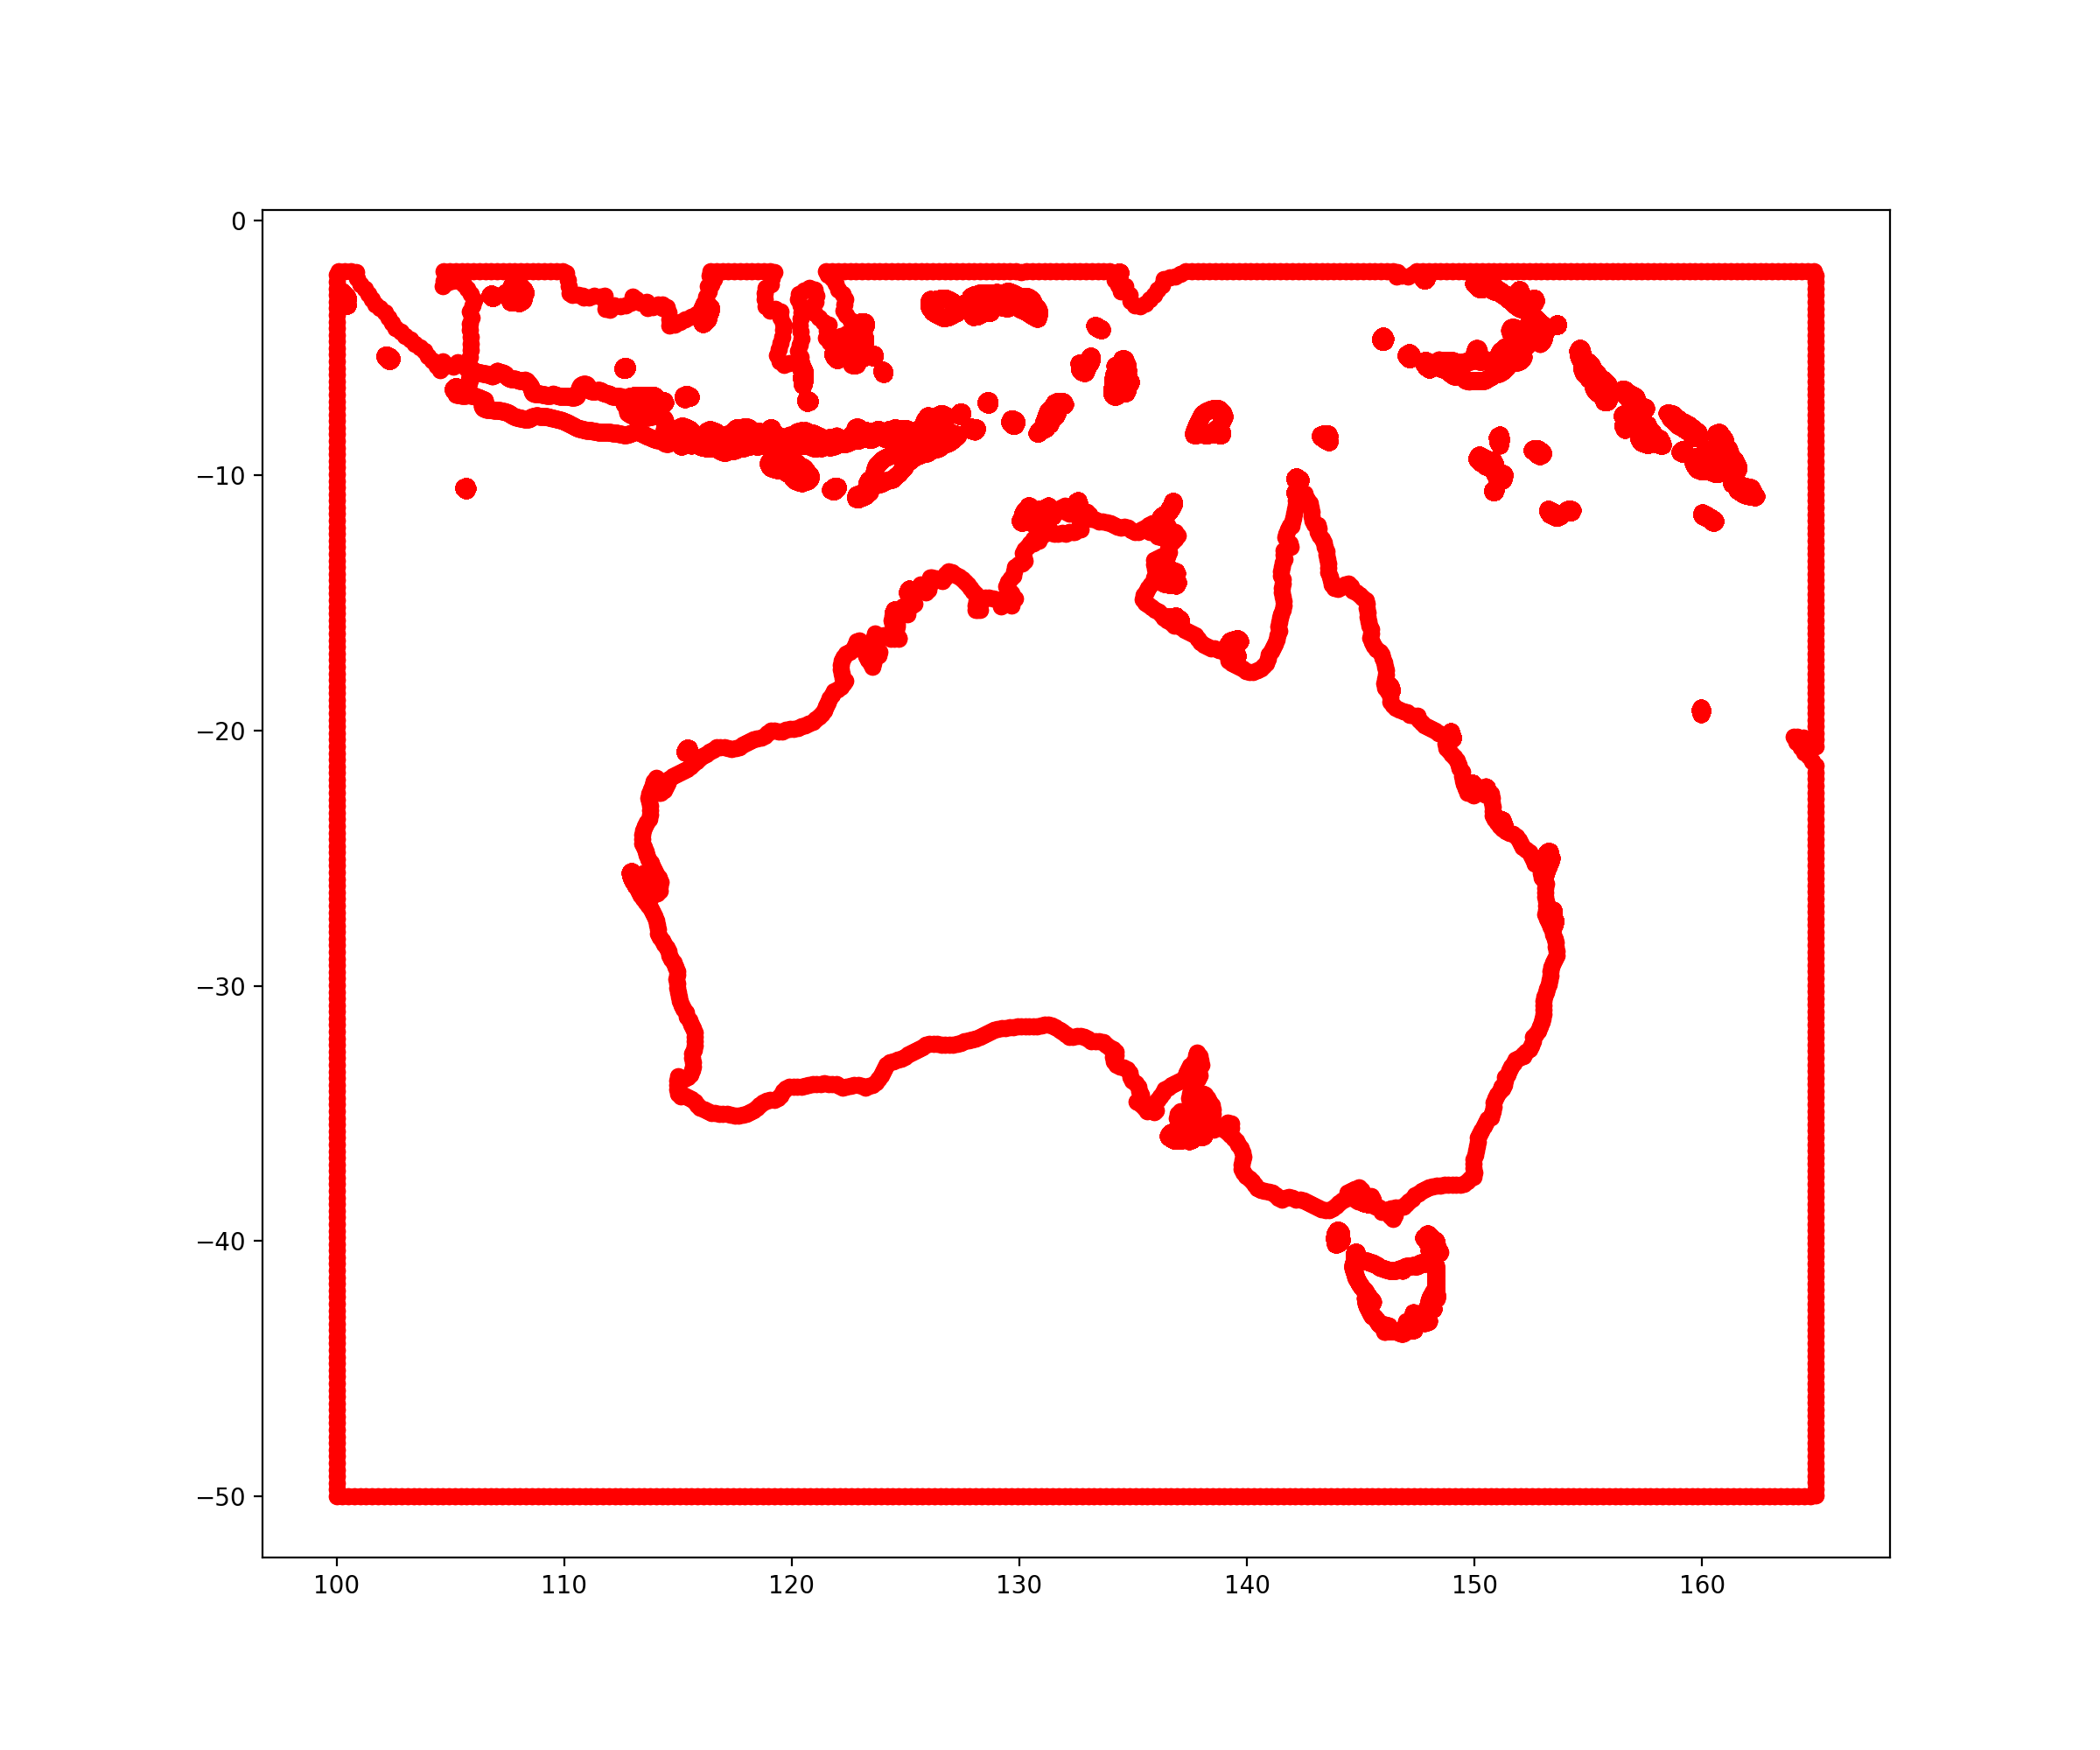

In [484]:
#plot e2
plt.figure(figsize=(12,10))
plt.scatter(elon,elat,c='r')

In [485]:
#plot e2
plt.figure(figsize=(12,10))
for index, row in e2.loc[:,['a','b']].iterrows():
    i, j = row['a'], row['b']
    p1 = (xy.x[i],xy.x[j])
    p2 = (xy.y[i],xy.y[j])
    plt.plot(p1,p2)

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

## Execute jigsaw

In [486]:
! /Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/bin/MAC-64/jigsaw64r /Users/brey/Downloads/JIGSAW/AUS.jig

 
#------------------------------------------------------------
#
#   ,o, ,o,       /                                 
#    `   `  e88~88e  d88~\   /~~~8e Y88b    e    / 
#   888 888 88   88 C888         88b Y88b  d8b  /   
#   888 888 "8b_d8"  Y88b   e88~-888  Y888/Y88b/  
#   888 888  /        888D C88   888   Y8/  Y8/     
#   88P 888 Cb      \_88P   "8b_-888    Y    Y    
# \_8"       Y8""8D                             
#
#------------------------------------------------------------
# JIGSAW: an unstructured mesh generation package.  
#------------------------------------------------------------
 
  JIGSAW VERSION 0.9.5

  Reading CFG. file...

  CFG. data summary...

  GEOM_FILE = /Users/brey/Downloads/JIGSAW/geo/AUS-GEOM.msh 
  MESH_FILE = /Users/brey/Downloads/JIGSAW/out/AUS.msh 
  HFUN_FILE = /Users/brey/Downloads/JIGSAW/out/AUS-HFUN.msh 

  GEOM_SEED = 8 
  GEOM_PHI1 = 6.00e+01 
  GEOM_PHI2 = 6.00e+01 
  GEOM_ETA1 = 4.50e+01 
  GEOM_ETA2 = 4.50e+01 
  GEOM_FEAT = FALSE 

  HFU

## read output .msh

In [166]:
#fmsh = '/Users/brey/GitHub/jigsaw-geo-matlab/jigsaw/out/AUS-MESH.msh'

In [7]:
fmsh = '/Users/brey/Downloads/JIGSAW/out/AUS.msh'

In [8]:
#extract number of elements, number of nodes
point,nn=pd.read_csv(fmsh,header=2,skiprows=1,nrows=0,delimiter='=')

In [9]:
nn

'264697'

In [10]:
nn=int(nn)

In [11]:
#read lon,lat,depth for all nodes
xy=pd.read_csv(fmsh,skiprows=4,header=None,delimiter=';',engine='python',nrows=nn,names=['x','y','z'])

In [12]:
xy.shape

(264697, 3)

In [13]:
xy.head()

x          y  z
0  164.893252  -2.000400  0
1  100.000000 -50.000000  0
2  150.190358 -50.000000  0
3  109.914595  -2.000400  0
4  137.428255 -16.123541  0

In [14]:
xy.tail()

x          y  z
264692  152.104000 -22.013473  0
264693  105.845153  -2.123980  0
264694  105.796283  -2.129224  0
264695  128.491279  -2.133598  0
264696  159.645568  -8.394286  0

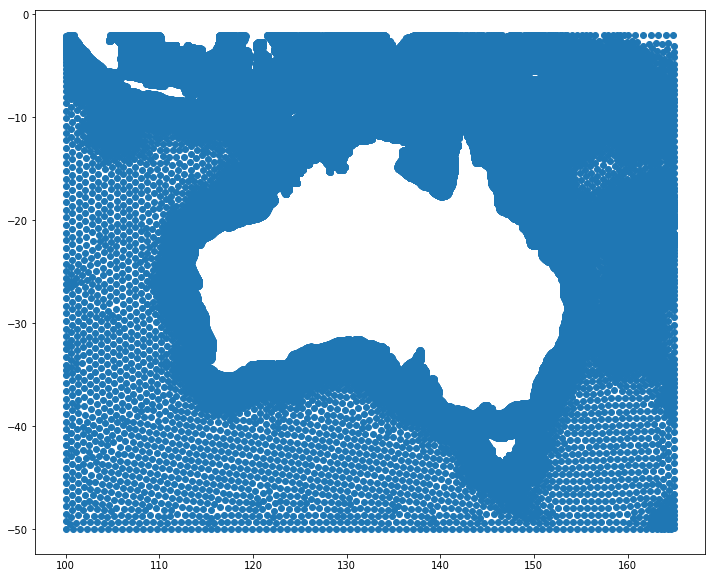

In [15]:
#plot xy points
plt.figure(figsize=(12,10))
plt.scatter(xy.x, xy.y)

In [16]:
power,pn=pd.read_csv(fmsh,header=4,skiprows=nn,nrows=0,delimiter='=')

In [17]:
power, pn

('POWER', '264697;1')

In [18]:
pn,s = pn.split(';')

In [19]:
pn = int(pn)

In [20]:
pr=pd.read_csv(fmsh,skiprows=nn+5,header=None,delimiter=';',engine='python',nrows=pn,names=['a'])

### EDGES

In [21]:
edge2,ne=pd.read_csv(fmsh,header=4,skiprows=nn+pn+1,nrows=0,delimiter='=')

In [22]:
ne = int(ne)

In [23]:
ne

13134

In [24]:
e2=pd.read_csv(fmsh,skiprows=nn+pn+6,header=None,delimiter=';',engine='python',nrows=ne,names=['a','b','c'])

In [25]:
e2.head()

a     b  c
0  3586  3743  0
1  7080  7082  0
2  4634  4940  0
3  3581  3706  0
4  5392  7088  0

In [26]:
e2.tail()

a      b  c
13129  8831  10193  0
13130   703    714  0
13131  9142  10281  0
13132  4546   4782  0
13133  6770   8841  0

In [27]:
#get edge lon/lat
elon=[]
elat=[]
for index, row in e2.loc[:,['a','b']].iterrows():
    i, j = row['a'], row['b']
    elon.append(xy.x[i])
    elat.append(xy.y[i])
    elon.append(xy.x[j])
    elat.append(xy.y[j])


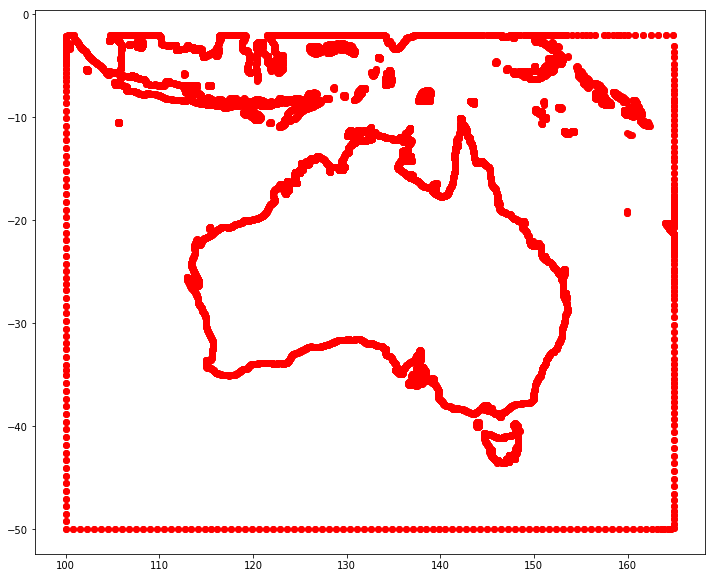

In [28]:
#plot e2
plt.figure(figsize=(12,10))
plt.scatter(elon,elat,c='r')


In [29]:
%matplotlib notebook

<IPython.core.display.Javascript object>


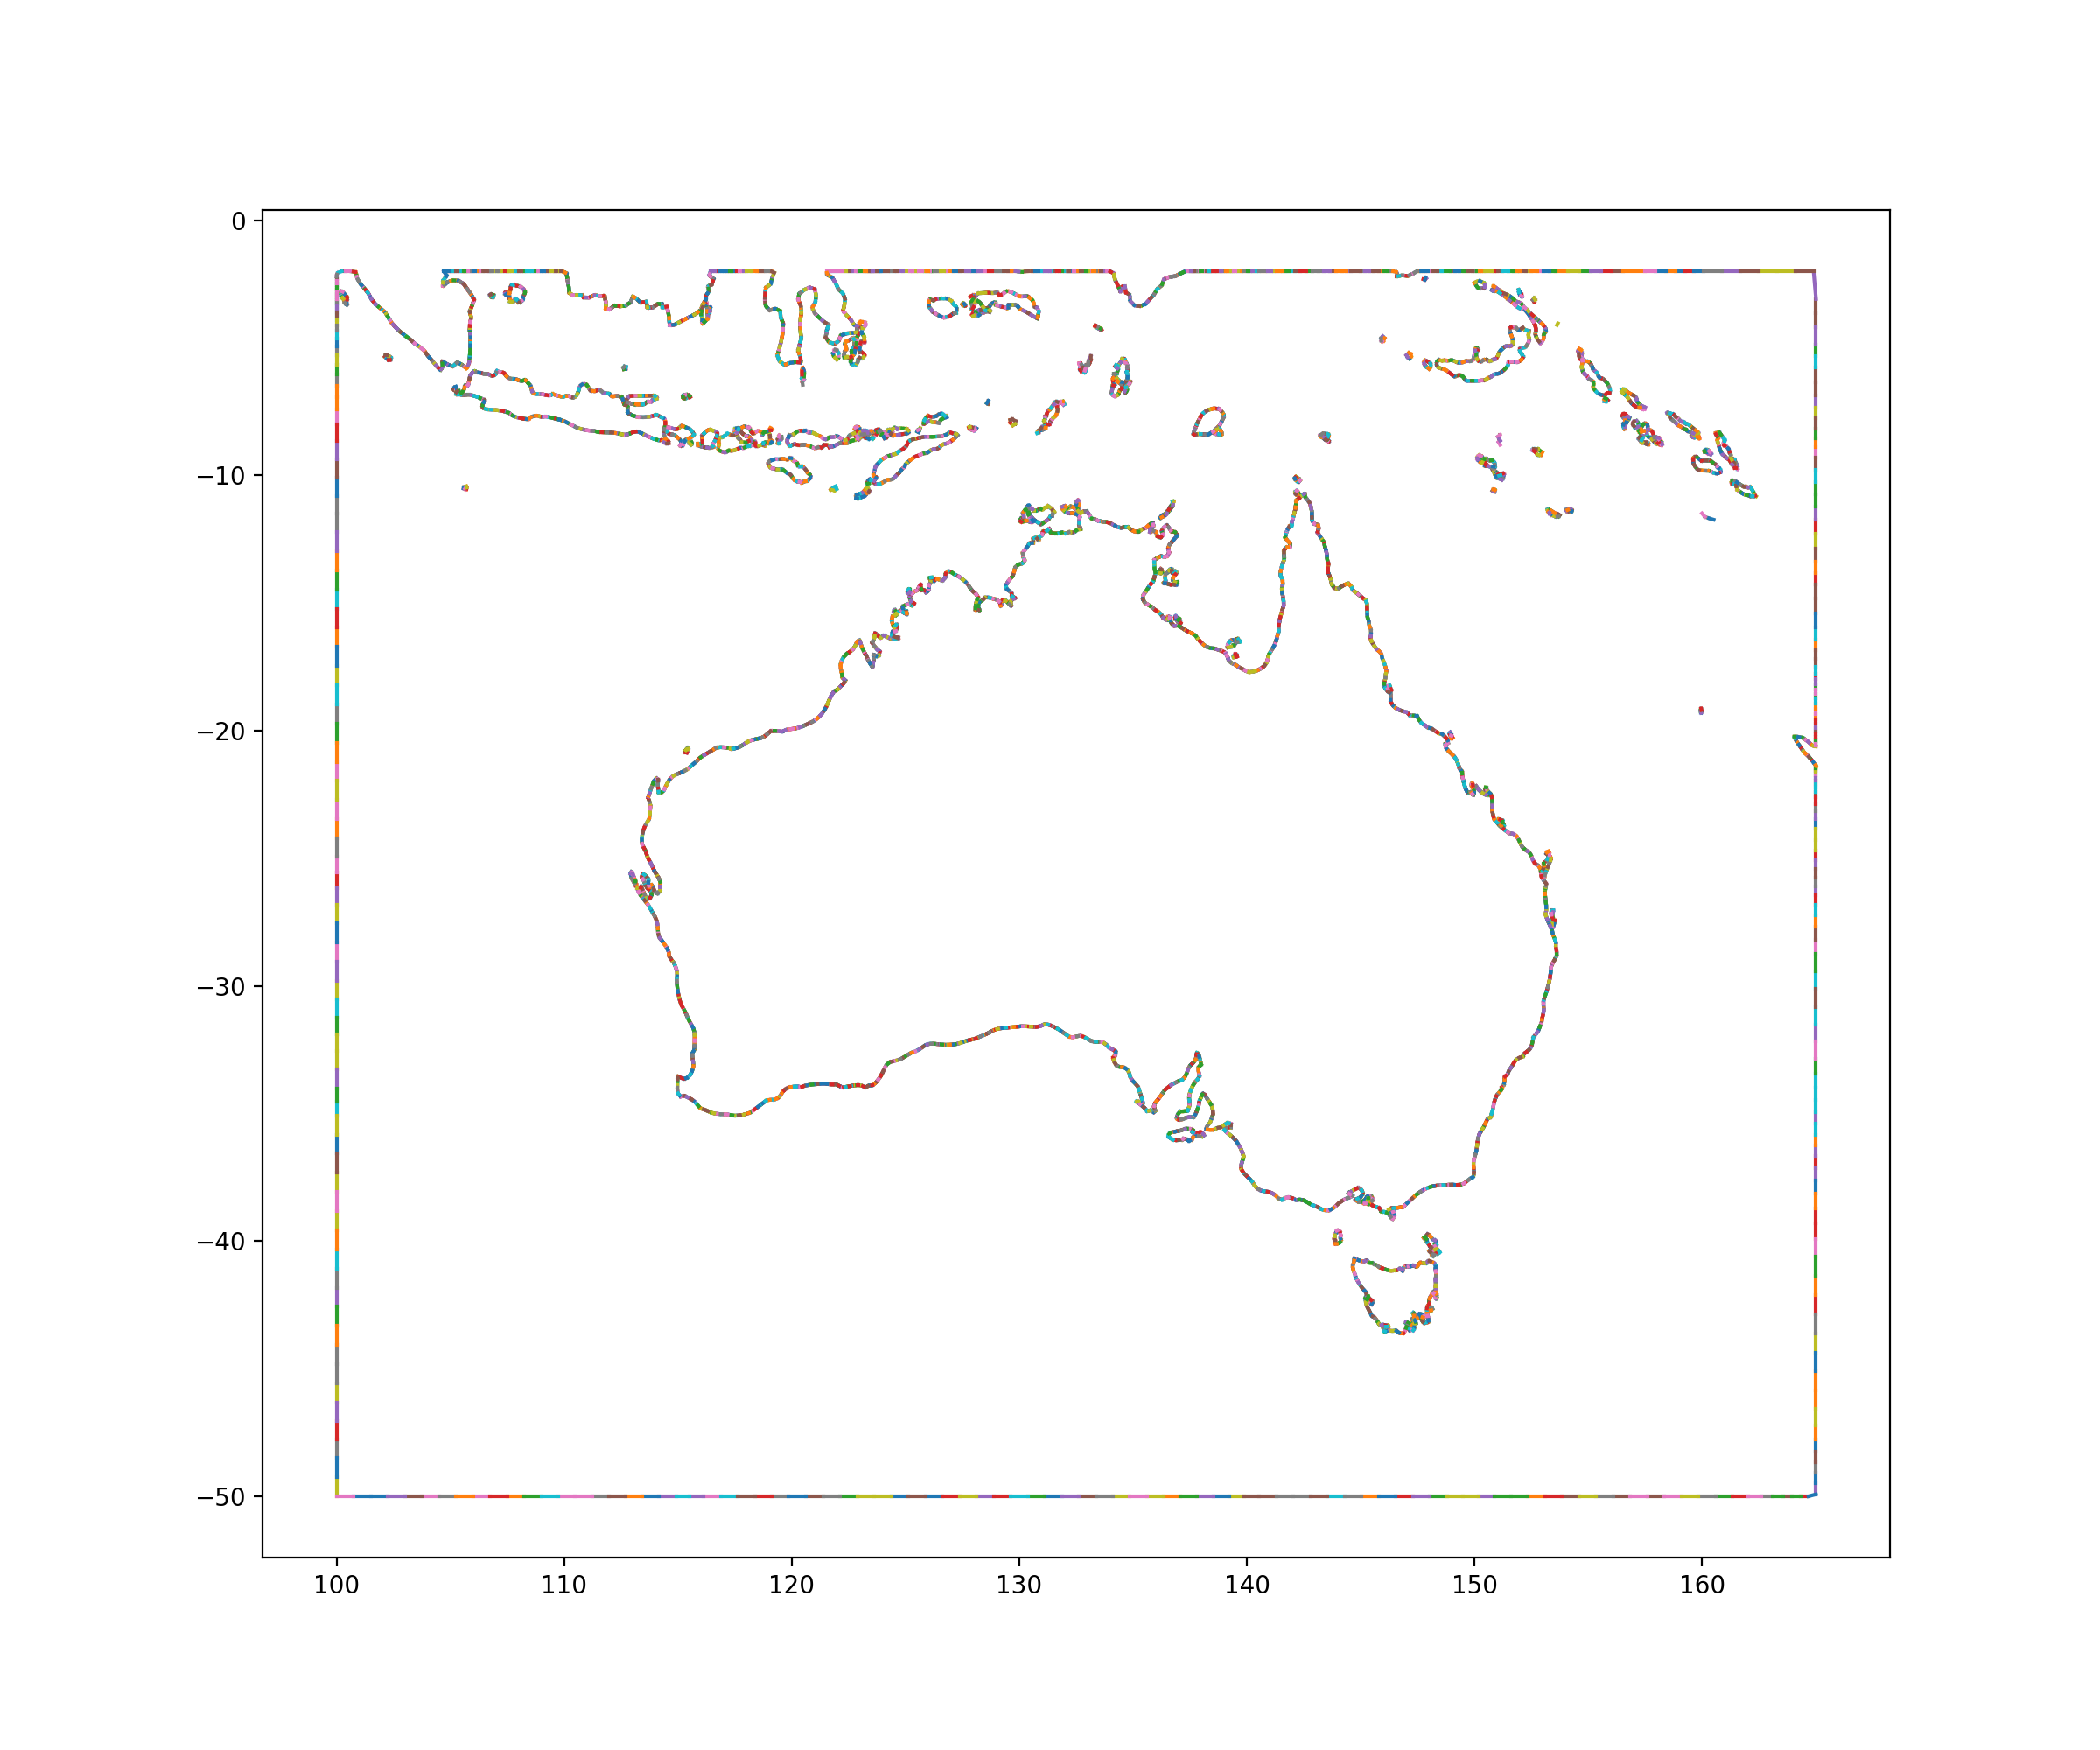

In [30]:
#plot e2
plt.figure(figsize=(12,10))
for index, row in e2.loc[:,['a','b']].iterrows():
    i, j = row['a'], row['b']
    p1 = (xy.x[i],xy.x[j])
    p2 = (xy.y[i],xy.y[j])
    plt.plot(p1,p2)


In [282]:
plt.scatter([one[0],two[0]],[one[1],two[1]], s=100)

In [189]:
sh = zip(elon,elat)

In [190]:
csh = [sh[i:i + 2] for i in xrange(0, len(sh), 2)]

In [191]:
mlist=[]
for i in range(len(csh)):
     mlist.append(geometry.LineString(csh[i]))

In [192]:
print mlist[4]

LINESTRING (122.5344621126653 -8.450904760653799, 122.5677489152087 -8.424282552802897)


In [193]:
sall = geometry.MultiLineString(mlist)

In [194]:
c = ops.linemerge(sall)

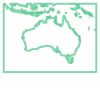

In [195]:
c

In [196]:
len(c)

176

In [262]:
one,two = c[2].coords[:]

In [264]:
one[0], one[1]

(123.19996304185013, -4.789826490808599)

In [259]:
for line in c:
    if len(line.coords[:]) == 2 : print line.coords[:]

[(120.48163105201859, -6.447622260483203), (120.46266428679456, -6.29447188869524)]
[(123.19996304185013, -4.789826490808599), (123.1917407679518, -4.8168296589933615)]
[(124.02348409849856, -5.903500392174787), (124.04568262019974, -6.002853728480155)]
[(125.60250200255008, -8.164373039585302), (125.64364967305045, -8.146248701603822)]
[(127.86922198227792, -3.017134845497859), (127.83725630004416, -3.002905053102941)]
[(127.98301260132007, -2.9380820959539533), (127.97306166851835, -2.961190281452978)]
[(128.4111367523696, -3.6318995359309247), (128.39410172903894, -3.6371238691853858)]
[(131.1428231896547, -8.128405170053956), (131.16990150467734, -8.13472302074446)]
[(132.8529025692383, -5.979650452608578), (132.85712128845518, -5.955984143724185)]
[(132.8857868482745, -5.944869003627922), (132.85712128845518, -5.955984143724185)]
[(133.01985166716585, -5.68336337405871), (132.9308063296514, -5.72676548612135)]
[(134.4324009938893, -2.773646036839536), (134.44142136477026, -2.79235

### TRIANGLES

In [197]:
edge3,n3e=pd.read_csv(fmsh,header=4,skiprows=nn+pn+ne+2,nrows=0,delimiter='=')

In [198]:
n3e

'516863'

In [199]:
n3e = int(n3e)

In [200]:
e3=pd.read_csv(fmsh,skiprows=nn+pn+ne+7,header=None,delimiter=';',engine='python',nrows=n3e,names=['a','b','c','q'])

In [201]:
e3.head()

a       b       c  q
0   36945  216313  233855  0
1  125349  105026  125350  0
2  111575  111577  111578  0
3  133432  133430  232146  0
4   85285   85284   86279  0

In [202]:
e3.tail()

a       b       c  q
516858   62856   51149   61107  0
516859   51228   22993   61107  0
516860   22993   62856   61107  0
516861  252332  264959  264084  0
516862   53398   67187   86266  0

In [203]:
e3['q']=3

In [204]:
e3.head()

a       b       c  q
0   36945  216313  233855  3
1  125349  105026  125350  3
2  111575  111577  111578  3
3  133432  133430  232146  3
4   85285   85284   86279  3

In [205]:
tri3 = e3.loc[:,['a','b','c']].values

In [206]:
tri3

array([[ 36945, 216313, 233855],
       [125349, 105026, 125350],
       [111575, 111577, 111578],
       ...,
       [ 22993,  62856,  61107],
       [252332, 264959, 264084],
       [ 53398,  67187,  86266]])

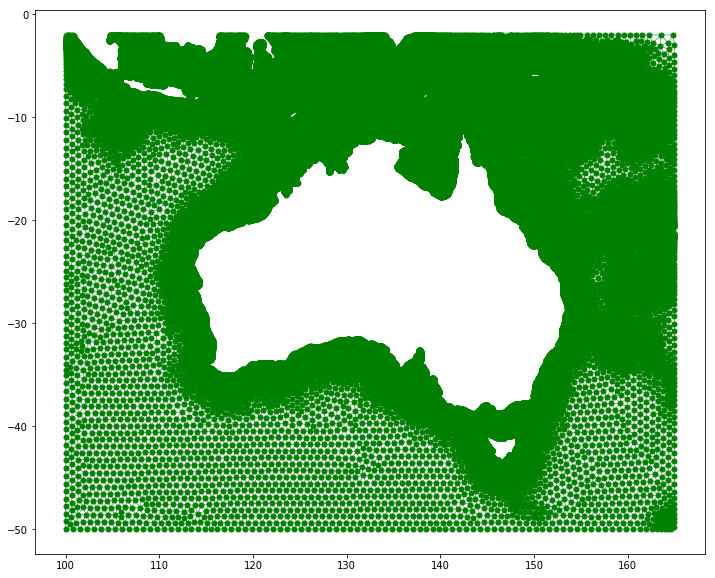

In [207]:
#plot e3
plt.figure(figsize=(12,10))
plt.triplot(xy.x, xy.y, tri3, 'go-', lw=.5, markersize=5 )
plt.show()

### Get depth

In [208]:
# Get Bathymetry
b = gebco(**{'minlon' : minlon, 'maxlon' :  maxlon, 'minlat' : minlat, 'maxlat' : maxlat, 'grid_x' : xy.x, 'grid_y' : xy.y,
            'dem': 'gebco',
            'dpath' : '/Users/brey/DATA/GEBCO_2014_2D.nc'})


extracting dem from /Users/brey/DATA/GEBCO_2014_2D.nc

dem done


In [209]:
b.dem

<xarray.Dataset>
Dimensions:  (dlat: 5759, dlon: 7799, i: 5759, j: 7799, k: 264961)
Coordinates:
  * dlat     (dlat) float64 -50.0 -49.99 -49.98 -49.97 -49.96 -49.95 -49.95 ...
  * dlon     (dlon) float64 100.0 100.0 100.0 100.0 100.0 100.0 100.1 100.1 ...
Dimensions without coordinates: i, j, k
Data variables:
    dlats    (i, j) float64 -50.0 -50.0 -50.0 -50.0 -50.0 -50.0 -50.0 -50.0 ...
    val      (dlat, dlon) float32 -3376.0 -3378.0 -3379.0 -3379.0 -3379.0 ...
    dlons    (i, j) float64 100.0 100.0 100.0 100.0 100.0 100.0 100.1 100.1 ...
    ival     (k) float32 -4470.0 -3376.0 -3999.0 -14.0 3.0 -3270.0 -3197.0 ...
    ilats    (k) float64 -2.0 -50.0 -50.0 -2.0 -16.17 -49.25 -50.0 -33.96 ...
    ilons    (k) float64 164.9 100.0 150.2 109.9 137.5 100.0 100.7 119.9 ...

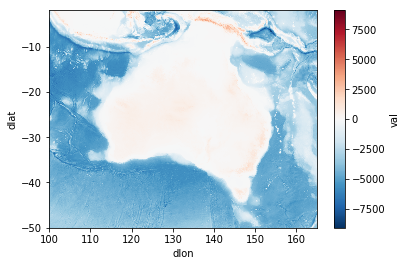

In [210]:
b.dem.val.plot()

In [211]:
b.dem.ival.max(), b.dem.ival.min()

(<xarray.DataArray 'ival' ()>
 array(4577.), <xarray.DataArray 'ival' ()>
 array(-8914.))

In [212]:
pp = np.argwhere(b.dem.ival.values > 0)

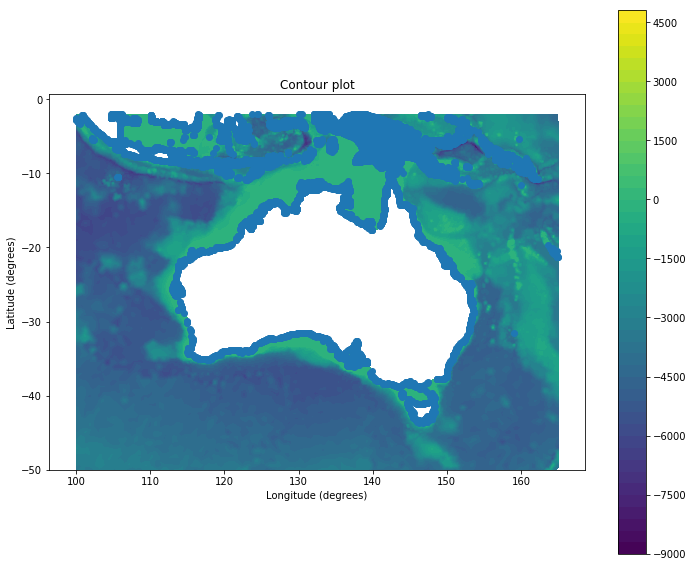

In [213]:
# plot bathymetry
plt.figure(figsize=(12,10))
plt.gca().set_aspect('equal')
plt.tricontourf(xy.x, xy.y, tri3, b.dem.ival, 50, )
plt.colorbar()
plt.scatter(b.dem.ilons.values[pp], b.dem.ilats.values[pp])
plt.title('Contour plot')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.show()

In [214]:
b.dem.ival[b.dem.ival>0] = -1. # fix???

# Save necessary input files for Schism

In [215]:
folder = '/Users/brey/SCHISM/test_grid_2/'

### hgrid.gr3

In [216]:
grid = xy.copy()
grid = grid.loc[:,:].astype(float)

In [217]:
grid.loc[:,'z'] = - b.dem.ival

In [218]:
grid.index = grid.index + 1 # change index start

In [219]:
grid.head()

x         y       z
1  164.893252  -2.00040  4470.0
2  100.000000 -50.00000  3376.0
3  150.190358 -50.00000  3999.0
4  109.914595  -2.00040    14.0
5  137.526367 -16.16709     1.0

In [220]:
grid.tail()

x         y       z
264957  148.079012 -2.142459  1029.0
264958  157.331013 -8.710031   121.0
264959  105.199092 -2.144320    13.0
264960  108.154673 -3.236313     2.0
264961  105.169339 -2.118708     9.0

In [221]:
g3file=folder+'hgrid.gr3'

In [222]:
with open(g3file,'w') as f:
    f.write('\t uniform.gr3\n')
    f.write('\t {} {}\n'.format(n3e,nn))
    

In [223]:
grid.to_csv(g3file,index=True, sep='\t', header=None,mode='a', float_format='%.10f', columns=['x','y','z'])

In [224]:
# Add one to reset the node counter
c3 = e3.copy()
c3.loc[:,['a']]=c3.loc[:,['a']]+1
c3.loc[:,['b']]=c3.loc[:,['b']]+1
c3.loc[:,['c']]=c3.loc[:,['c']]+1
c3.index = c3.index + 1 # adjust index start
c3.head()

a       b       c  q
1   36946  216314  233856  3
2  125350  105027  125351  3
3  111576  111578  111579  3
4  133433  133431  232147  3
5   85286   85285   86280  3

In [225]:
c3.to_csv(g3file,index=True, sep='\t', header=None, mode='a', columns=['q','a','b','c'])

## identify the node numbers of boundaries

In [226]:
gf = gp.GeoDataFrame(gp.GeoSeries(c[0]))

In [227]:
gf.columns.names

FrozenList([None])

In [228]:
#Make a geopandas dataframe
gf = gp.GeoDataFrame(gp.GeoSeries(c[0]))
for line in c[1:]:
    gf = pd.concat([gf,gp.GeoDataFrame(gp.GeoSeries(line))], ignore_index=True)

In [229]:
gf.columns = ['geometry'] # name column

In [230]:
gf['length']=gf['geometry'][:].length 

In [231]:
gf.head()

geometry    length
0  LINESTRING (120.4626642867946 -6.2944718886952...  1.029230
1  LINESTRING (120.4816310520186 -6.4476222604832...  0.154320
2  LINESTRING (123.1999630418501 -4.7898264908085...  0.028227
3  LINESTRING (123.1999630418501 -4.7898264908085...  3.565819
4  LINESTRING (124.0234840984986 -5.9035003921747...  0.101803

In [232]:
gf.loc[gf.length == gf.length.max()]

geometry      length
26  LINESTRING (134.4324009938893 -2.7736460368395...  254.787901

In [233]:
# find the box boundary line MAYBE IT CAN BE DONE BETTER?
for i in range(gf.shape[0]):
    if (minlon in [a for (a,b) in gf.loc[i,'geometry'].coords[:]]) | (maxlon in [a for (a,b) in gf.loc[i,'geometry'].coords[:]]) | \
            (minlat in [b for (a,b) in gf.loc[i,'geometry'].coords[:]]) | (maxlat in [b for (a,b) in gf.loc[i,'geometry'].coords[:]]) : print i

26


In [643]:
#Shapely option
#points = shapely.geometry.MultiPoint(cr) 

#splitted = shapely.ops.split(c[26],points)

#len(splitted)

#plt.figure()
#for lin in splitted:
#    line = np.array([item for sublist in lin.coords[:] for item in sublist]).reshape([-1,2])
#    plt.plot(line[:,0],line[:,1])

In [234]:
C = gf.loc[26, 'geometry'].coords[:]
bxy = np.array([item for sublist in C for item in sublist]).reshape([-1,2])

In [235]:
pdb = pd.DataFrame(bxy, columns=['lon','lat'])

In [236]:
# wet parts

In [237]:
widx = pdb.loc[(pdb.lon == minlon) | (pdb.lon == maxlon) | (pdb.lat == minlat) | (pdb.lat == maxlat)].index.values

In [238]:
wetp = [map(itemgetter(1), g) for k, g in groupby(enumerate(widx), lambda (i,x):i-x)]

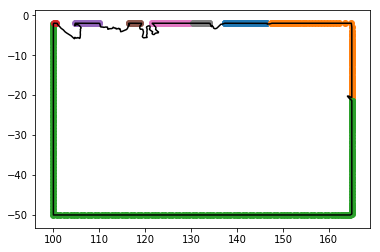

In [239]:
#check
plt.figure()
plt.plot(pdb.lon,pdb.lat,'k-')

for i in range(len(wetp)):
    plt.scatter(pdb.loc[wetp[i]].lon,pdb.loc[wetp[i]].lat)


In [240]:
# land parts

In [241]:
lidx = list(set(range(0,pdb.shape[0])) - set(widx))

In [242]:
landp = [map(itemgetter(1), g) for k, g in groupby(enumerate(lidx), lambda (i,x):i-x)]

In [603]:
%matplotlib notebook

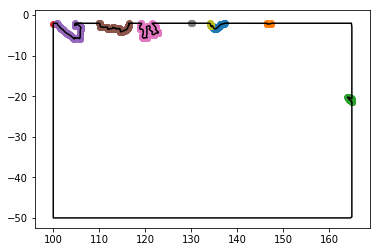

In [243]:
#check
plt.figure()
plt.plot(pdb.lon,pdb.lat,'k-')


for i in range(len(landp)):
    plt.scatter(pdb.loc[landp[i]].lon,pdb.loc[landp[i]].lat)

In [244]:
## Get global indices for wet parts
fidx=[]
for line in wetp:
    idx=[]
    for i in range(len(line)):
        bx,by = pdb.loc[line,['lon','lat']].values[i]
        idx.append(grid.loc[(grid['x'] == bx) & (grid['y'] == by)].index.values)
    fidx.append([item for sublist in idx for item in sublist])

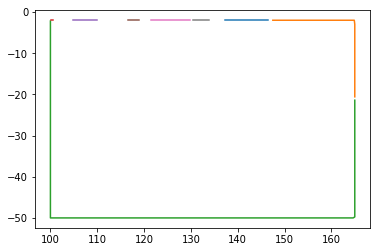

In [245]:
#check wet boundaries
plt.figure()
for idx in fidx:
    plt.plot(grid.loc[idx,'x'],grid.loc[idx,'y'])

In [246]:
tnob = len([item for sublist in fidx for item in sublist])

In [247]:
with open(g3file, 'a') as f:
    f.write('{} = Number of open boundaries\n'.format(len(fidx)))
    f.write('{} = Total number of open boundary nodes\n'.format(tnob))
    for i in range(len(fidx)):
        f.write('{} = Number of nodes for open boundary {}\n'.format(len(fidx[i]),i+1))
        for item in fidx[i]:
            f.write("%s\n" % item)

In [248]:
## Get global indices for land parts
lidx=[]
for line in landp:
    idx=[]
    for i in range(len(line)):
        bx,by = pdb.loc[line,['lon','lat']].values[i]
        idx.append(grid.loc[(grid['x'] == bx) & (grid['y'] == by)].index.values)
    lidx.append([item for sublist in idx for item in sublist])

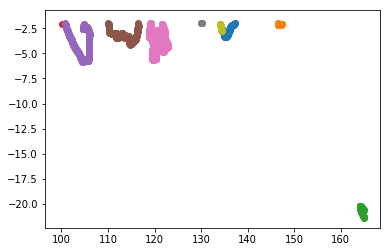

In [249]:
#check wet boundaries
plt.figure()
for idx in lidx:
    plt.scatter(grid.loc[idx,'x'],grid.loc[idx,'y'])

In [250]:
# Get internal boundaries 
ls = [x for x in range(gf.shape[0]) if x != 26] # remove the top boundary
ilidx = []
for i in ls:
    C = gf.loc[i, 'geometry'].coords[:]
    bxy = np.array([item for sublist in C for item in sublist]).reshape([-1,2])
    idf = pd.DataFrame(bxy, columns=['lon','lat'])
    idx=[]
    for i in range(bxy.shape[0]):
        bx,by = idf.values[i]
        idx.append(grid.loc[(grid['x'] == bx) & (grid['y'] == by)].index.values)

    ilidx.append([item for sublist in idx for item in sublist])

In [251]:
# combine the 2 list of lists
tlist = ilidx + lidx

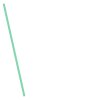

In [253]:

c[4]

<IPython.core.display.Javascript object>


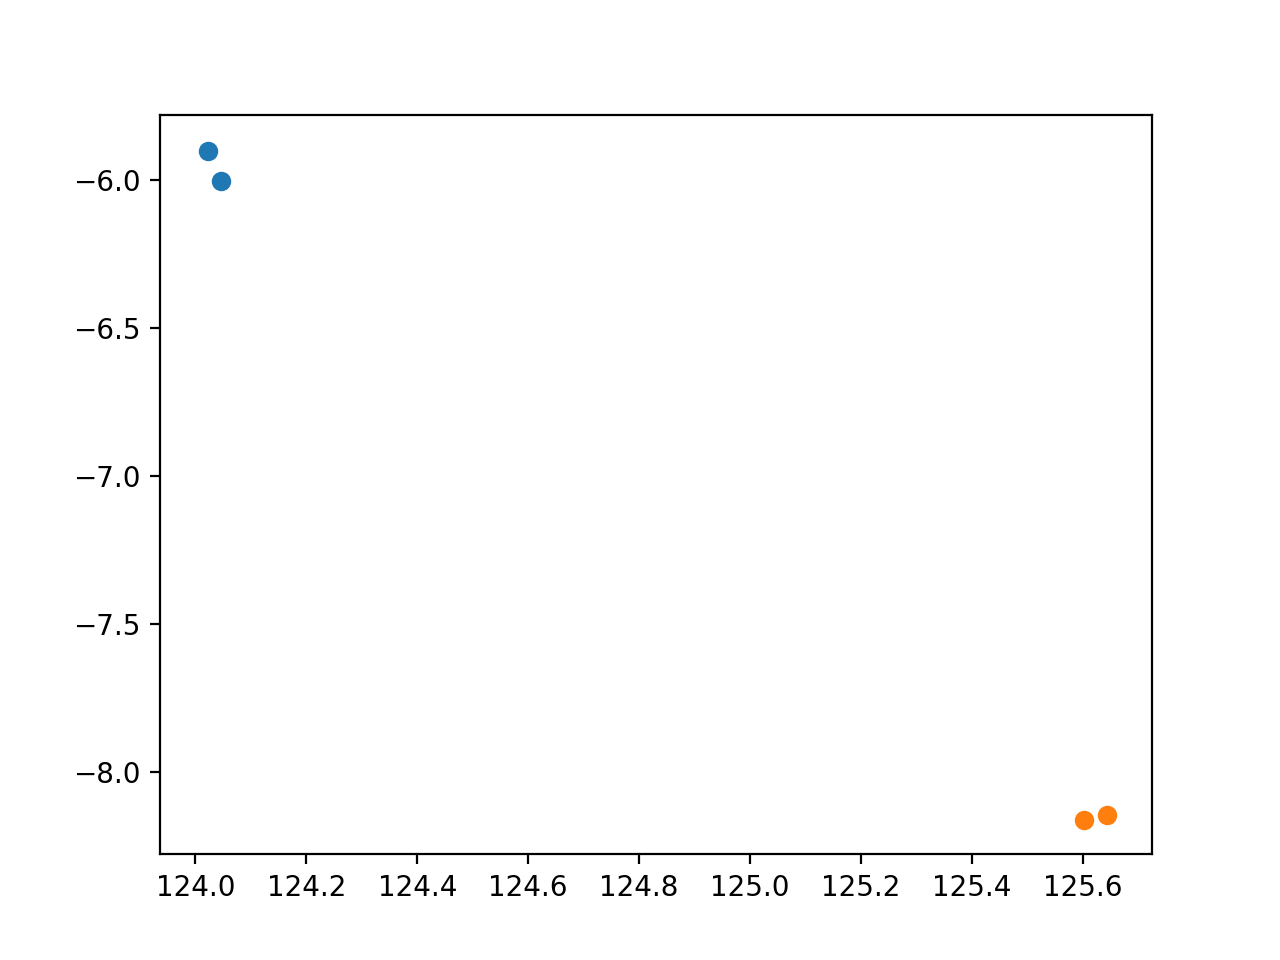

In [723]:
#check land boundaries
plt.figure()
for idx in tlist[4:6]:
    plt.scatter(grid.loc[idx,'x'],grid.loc[idx,'y'])

In [671]:
tnlb = len([item for sublist in tlist for item in sublist])

In [672]:
with open(g3file, 'a') as f:
    f.write('{} = Number of land boundaries\n'.format(len(tlist)))
    f.write('{} = Total number of land boundary nodes\n'.format(tnlb))
    for i in range(len(tlist)):    
        f.write('{} 1 = Number of nodes for land boundary {}\n'.format(len(tlist[i]),i+1))
        for item in tlist[i]:
            f.write("%s\n" % item)

### hgrid.ll

In [673]:
llfile=folder+'hgrid.ll'

In [674]:
copyfile(g3file, llfile)

### manning.gr3

In [675]:
manfile=folder+'manning.gr3'

In [676]:
with open(manfile,'w') as f:
    f.write('\t 0 \n')
    f.write('\t {} {}\n'.format(n3e,nn))

In [677]:
grid['man']=.12
grid.head()

x         y       z   man
1  164.893252  -2.00040  4470.0  0.12
2  100.000000 -50.00000  3376.0  0.12
3  150.190358 -50.00000  3999.0  0.12
4  109.914595  -2.00040    14.0  0.12
5  137.526367 -16.16709     1.0  0.12

In [678]:
grid.to_csv(manfile,index=True, sep='\t', header=None,mode='a', float_format='%.10f',columns=['x','y','man'] )

In [679]:
c3.to_csv(manfile,index=True, sep='\t', header=None, mode='a', columns=['q','a','b','c'])

### windrot_geo2proj.gr3

In [680]:
windfile=folder+'windrot_geo2proj.gr3'

In [681]:
with open(windfile,'w') as f:
    f.write('\t 0 \n')
    f.write('\t {} {}\n'.format(n3e,nn))

In [682]:
grid['windrot']=0.000001
grid.head()

x         y       z   man   windrot
1  164.893252  -2.00040  4470.0  0.12  0.000001
2  100.000000 -50.00000  3376.0  0.12  0.000001
3  150.190358 -50.00000  3999.0  0.12  0.000001
4  109.914595  -2.00040    14.0  0.12  0.000001
5  137.526367 -16.16709     1.0  0.12  0.000001

In [683]:
grid.to_csv(windfile,index=True, sep='\t', header=None,mode='a', float_format='%.10f',columns=['x','y','windrot'] )

In [684]:
c3.to_csv(windfile,index=True, sep='\t', header=None, mode='a', columns=['q','a','b','c'])

## Get uvp forcing

In [685]:
meteo = gfs_erdap(**{'minlon':minlon-.1, # lat/lon window
     'maxlon':maxlon+.1,
     'minlat':minlat-.1,
     'maxlat':maxlat+.1,
     'start_date':'2013-10-28',
     'end_date':'2013-10-29',
    })


extracting meteo from https://bluehub.jrc.ec.europa.eu/erddap/griddap/NCEP_Global_Best.html

meteo done


In [686]:
xx, yy = np.meshgrid(meteo.uvp.longitude.data, meteo.uvp.latitude.data)

In [687]:
zero = np.zeros(meteo.uvp.msl.data.shape)

In [688]:
tlist = (meteo.uvp.time.data - meteo.uvp.time.data[0]).astype('timedelta64[s]')/3600.

In [689]:
tlist = tlist.astype(float)/24.

In [690]:
udate = pd.to_datetime(meteo.uvp.time[0].data).strftime('%Y-%m-%d')

In [691]:
bdate = pd.to_datetime(meteo.uvp.time[0].data).strftime('%Y %m %d %H').split(' ')

In [692]:
bdate = [int(q) for q in bdate]

In [693]:
sout= xr.Dataset({'prmsl':(['time', 'nx_grid', 'ny_grid'], meteo.uvp.msl.data),
                  'uwind':(['time','nx_grid','ny_grid'], meteo.uvp.u10.data),
                  'vwind':(['time','nx_grid','ny_grid'], meteo.uvp.v10.data),
                  'spfh':(['time','nx_grid','ny_grid'], zero),
                  'stmp':(['time','nx_grid','ny_grid'], zero),
                  'lon':(['nx_grid','ny_grid'], xx),
                  'lat':(['nx_grid','ny_grid'], yy)},
             coords={'time':tlist})

In [694]:
sout.attrs={'description' : 'Schism forsing',
    'history' :'JRC Ispra European Commission',
    'source' : 'netCDF4 python module'}

In [695]:
sout.time.attrs={   'long_name':      'Time',
                    'standard_name':  'time',
                    'base_date':      bdate,
                    'units':          udate}

In [696]:
sout.lon.attrs={'units': 'degrees_east',
               'long_name': 'Longitude',
               'standard_name':'longitude'}

In [697]:
sout.lat.attrs={'units': 'degrees_north',
               'long_name': 'Latitude',
               'standard_name':'latitude'}

In [698]:
sout.prmsl.attrs={'units': 'Pa',
               'long_name': 'Pressure reduced to MSL',
               'standard_name':'air_pressure_at_sea_level'}

In [699]:
sout.uwind.attrs={'units': 'm/s',
               'long_name': 'Surface Eastward Air Velocity',
               'standard_name':'eastward_wind'}

In [700]:
sout.vwind.attrs={'units': 'm/s',
               'long_name': 'Surface Northward Air Velocity',
               'standard_name':'northward_wind'}

In [701]:
sout.spfh.attrs={'units': '1',
               'long_name': 'Surface Specific Humidity (2m AGL)',
               'standard_name':'specific_humidity'}

In [702]:
sout.stmp.attrs={'units': 'degrees',
               'long_name': 'Surface Temperature',
               'standard_name':'surface temperature'}

In [703]:
if not os.path.exists(folder + 'sflux'):
            os.makedirs(folder + 'sflux')

In [704]:
sout.to_netcdf(folder+'sflux/sflux_air_1.001.nc')

### sflux_inputs.txt

In [705]:
with open(folder+'sflux/sflux_inputs.txt', 'w') as f:
    f.write('&sflux_inputs\n')
    f.write('/ \n\n')

### param.in

In [706]:
sim = pd.to_datetime(meteo.uvp.time[0].values)
sim

Timestamp('2013-10-28 00:00:00')

In [707]:
dic = {
  'PH': 1,
  'airt': 0,
  'bage_elem':0,
  'bdrc': 0,
  'bfric': -1,
  'bpgr_side': 0,
  'bthk_elem': 0,
  'btrack_nudge': 1.013e-3,
  'conc': 0,
  'consv_check': 0,
  'courant_weno': 0.5,
  'cpp_lat': 36,
  'cpp_lon': -6,
  'dahv': 0,
  'depth_zsigma': 100.,
  'dramp': 1.,
  'dramp_ss': 2,
  'drampbc': 1.,
  'dt': 400,
  'dtb_max': 30.,
  'dtb_min': 30.,
  'eco_class': 27,
  'elev': 1,
  'eps1_tvd_imp': 1.e-4,
  'eps2_tvd_imp': 1.e-14,
  'epsilon1': 1.e-3,
  'epsilon2': 1.e-10,
  'epsilon3': 1.e-25,
  'evap': 0,
  'flag_fib': 1,
  'fllu': 0,
  'flsu': 0,
  'flux': 0,
  'gen_wsett': 1.e-4,
  'h0': 0.5,
  'h_tvd': 5.,
  'hmin_man': 1,
  'hmin_radstress': 0.,
  'hotout': 0,
  'hotout_write': 1440,
  'hvel': 1 ,
  'hvel_side': 0,
  'hvis_coef0': 0.025,
  'ibcc': 1,
  'ibcc_mean': 0,
  'ibtrack_test': 0,
  'ic_elev': 0,
  'icou_elfe_wwm': 0,
  'ics': 2,
  'ielad_weno': 0,
  'ieos_pres': 0,
  'ieos_type': 0,
  'if_source': 0,
  'iharind': 0,
  'ihconsv': 0,
  'ihdif': 0,
  'ihfskip': 36,
  'ihhat': 1,
  'ihorcon': 0,
  'ihot': 0,
  'ihydraulics': 0,
  'imm': 0,
  'indvel': 1,
  'inter_mom': 0,
  'inu_AGE': 0,
  'inu_COS': 0,
  'inu_ECO': 0,
  'inu_FIB': 0,
  'inu_GEN': 0,
  'inu_ICM': 0,
  'inu_SAL': 0,
  'inu_SED': 0,
  'inu_TEM': 0,
  'inu_elev': 0,
  'inu_uv': 0,
  'inunfl': 0,
  'inv_atm_bnd': 0,
  'iout_sta': 0,
  'ip_weno': 2,
  'ipre': 0,
  'irouse_test': 0,
  'isav': 0,
  'isconsv': 0,
  'ishapiro': 0,
  'itr_met': 1,
  'itransport': 0,
  'itur': 0,
  'iupwind_mom': 0,
  'iwbl': 0,
  'izonal5': 0,
  'kine': 0,
  'kr_co': 1,
  'mdc2': 10,
  'mixl': 0,
  'mrsh_elem': 0,
  'msc2': 10,
  'mxitn': 1500,
  'nadv': 1,
  'ncor': 1,
  'nquad': 2,
  'nramp': 1,
  'nramp_elev': 0,
  'nramp_ss': 1,
  'nrampbc': 0,
  'nspool': 9,
  'nspool_sta': 10,
  'nstep_ice': 1,
  'nstep_wwm': 1,
  'ntd_weno': 1,
  'nws': 2,
  'prcp': 0,
  'pres': 0,
  'prmsl_ref': 101325.,
  'qnon': 0,
  'radd': 0,
  'radu': 0,
  'rearth_eq': 6378206.4,
  'rearth_pole': 6378206.4,
  'rho0': ' 1000.d0',
  'rmaxvel': 50.,
  'rnday': 0.5,
  's1_mxnbt': 0.5,
  's2_mxnbt': 3.0,
  'salt': 1,
  'salt_elem': 0,
  'sav_cd': 1.13,
  'sed_class': 5,
  'shapiro': 0.5,
  'shum': 0,
  'shw': ' 4184.d0',
  'slr_rate': 120.,
  'slvr_output_spool': 50,
  'small_elad': 1.e-4,
  'srad': 0,
  'start_day': 28,
  'start_hour': 0,
  'start_month': 10,
  'start_year': 2013,
  'step_nu_tr': 86400.,
  'tdff': 0,
  'temp': 1,
  'temp_elem': 0,
  'thetai': 1,
  'tolerance': 1.e-12,
  'turb_met': ' KL ',
  'turb_stab': ' KC ',
  'utc_start': 0,
  'vdff': 0,
  'velmin_btrack':1.e-4,
  'vert': 1,
  'vert_elem': 0,
  'wave_force_side':0,
  'wind': 0,
  'wist': 0,
  'wtiminc': 400.,
  'xlsc0': 0.1,
  'z0st_elem': 0,
  'zcor': 1,
  'iwind_form': -1,
  'nrampwind': 1,
  'drampwind': 2,
  'iwindoff': 0,
  'dfv0': 0,
  'dfh0': 1.e-6,
  'ic_TEM': 1,
  'ic_SAL': 1
}

In [708]:
params = pd.DataFrame.from_dict(dic,orient = 'index')

In [709]:
#save
params.to_csv(folder + 'param.in', header=None, sep='=')

### bctides.in 

In [714]:
with open(folder + 'bctides.in', 'w') as f:
    f.write('Header\n')
    f.write('{} {}\n'.format(0, 40.)) #  ntip tip_dp
    f.write('{}\n'.format(0)) #nbfr
    f.write('{}\n'.format(tnob)) #number of open boundaries
    for i in range(len(fidx)):
        f.write('{} {} {} {} {}\n'.format(len(fidx[i]),2,0,0,0)) # number of nodes on the open boundary segment j (corresponding to hgrid.gr3), B.C. flags for elevation, velocity, temperature, and salinity
        f.write('{}\n'.format(0)) # ethconst !constant elevation value for this segment

### vgrid.in

In [715]:
with open(folder + 'vgrid.in', 'w') as f:
    f.write('{}\n'.format(2)) #ivcor (1: LSC2; 2: SZ)
    f.write('{} {} {}\n'.format(2,1,1.e6)) #nvrt(=Nz); kz (# of Z-levels); hs (transition depth between S and Z)
    f.write('Z levels\n') # Z levels !Z-levels in the lower portion
    f.write('{} {}\n'.format(1,-1.e6)) #!level index, z-coordinates, z-coordinate of the last Z-level must match -hs 
    f.write('S levels\n') # S-levels below 
    f.write('{} {} {}\n'.format(40.,1.,1.e-4))  #constants used in S-transformation: h_c, theta_b, theta_f
    f.write('{} {}\n'.format(1,-1.)) #first S-level (sigma-coordinate must be -1)
    f.write('{} {}\n'.format(2,0.)) # levels index, sigma-coordinate, last sigma-coordinate must be 0


### launchSchism.sh

In [716]:
with open(folder + 'launchSchism.sh', 'w') as f:
    f.write('source activate mpi2\n')
    f.write('exec=/Users/brey/SCHISM/v5.6.1/src/schism.ex_VL\n')
    f.write('mkdir outputs\n')
    f.write('mpirun -N 4 $exec\n')

In [717]:
#make it executable
execf = folder+'launchSchism.sh'
mode = os.stat(execf).st_mode
mode |= (mode & 0o444) >> 2    # copy R bits to X
os.chmod(execf, mode)


## Execute Schism

In [718]:
ex=subprocess.Popen(args=[folder+'./launchSchism.sh'], cwd=folder, shell=True, stderr=subprocess.PIPE, stdout=subprocess.PIPE, bufsize=1)
for line in iter(ex.stderr.readline, b''):
    print line,
ex.stderr.close()
for line in iter(ex.stdout.readline, b''):
    print line,
ex.stdout.close()

mkdir: outputs: File exists
application called MPI_Abort(comm=0x84000002, 0) - process 1
   1: ABORT:  Illegal bnd node         592          -1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [282]:
#execute combine
ex=subprocess.Popen(args=['/Users/brey/SCHISM/v5.6.1/src/Utility/Combining_Scripts/autocombine_MPI_elfe.pl 0 3'], cwd=folder, shell=True, stderr=subprocess.PIPE, stdout=subprocess.PIPE, bufsize=1)
for line in iter(ex.stderr.readline, b''):
    print line,
ex.stderr.close()
for line in iter(ex.stdout.readline, b''):
    print line,
ex.stdout.close()

/Users/brey/SCHISM/v5.6.1/src/Utility/Combining_Scripts/autocombine_MPI_elfe.pl 0 3


### Data Visualization

In [283]:
cfiles = glob.glob(folder+'outputs/schout_[!00].nc')
cfiles.sort()
cfiles

['/Users/brey/SCHISM/test_grid_2/outputs/schout_1.nc',
 '/Users/brey/SCHISM/test_grid_2/outputs/schout_2.nc',
 '/Users/brey/SCHISM/test_grid_2/outputs/schout_3.nc']

In [284]:
out = xr.open_mfdataset(cfiles)

In [285]:
out

<xarray.Dataset>
Dimensions:                  (nMaxSCHISM_hgrid_face_nodes: 4, nSCHISM_hgrid_edge: 1109, nSCHISM_hgrid_face: 702, nSCHISM_hgrid_node: 407, nSCHISM_vgrid_layers: 2, one: 1, sigma: 2, time: 12, two: 2)
Coordinates:
  * sigma                    (sigma) float32 -1.0 0.0
  * time                     (time) datetime64[ns] 2013-10-28T01:00:00 ...
Dimensions without coordinates: nMaxSCHISM_hgrid_face_nodes, nSCHISM_hgrid_edge, nSCHISM_hgrid_face, nSCHISM_hgrid_node, nSCHISM_vgrid_layers, one, two
Data variables:
    SCHISM_hgrid             (time, one) int32 dask.array<shape=(12, 1), chunksize=(4, 1)>
    SCHISM_hgrid_face_nodes  (time, nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 dask.array<shape=(12, 702, 4), chunksize=(4, 702, 4)>
    SCHISM_hgrid_edge_nodes  (time, nSCHISM_hgrid_edge, two) int32 dask.array<shape=(12, 1109, 2), chunksize=(4, 1109, 2)>
    SCHISM_hgrid_node_x      (time, nSCHISM_hgrid_node) float32 dask.array<shape=(12, 407), chunksize=(4, 407)>
 

In [286]:
out.time

<xarray.DataArray 'time' (time: 12)>
array(['2013-10-28T01:00:00.000000000', '2013-10-28T02:00:00.000000000',
       '2013-10-28T03:00:00.000000000', '2013-10-28T04:00:00.000000000',
       '2013-10-28T05:00:00.000000000', '2013-10-28T06:00:00.000000000',
       '2013-10-28T07:00:00.000000000', '2013-10-28T08:00:00.000000000',
       '2013-10-28T09:00:00.000000000', '2013-10-28T10:00:00.000000000',
       '2013-10-28T11:00:00.000000000', '2013-10-28T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-10-28T01:00:00 2013-10-28T02:00:00 ...
Attributes:
    long_name:      Time
    base_date:       2013 10 28       0.00       0.00
    standard_name:  time

In [287]:
h=out.elev.values

In [288]:
h.mean()

-0.00012314781

In [289]:
t = out.variables['time'][:]
t.values

array(['2013-10-28T01:00:00.000000000', '2013-10-28T02:00:00.000000000',
       '2013-10-28T03:00:00.000000000', '2013-10-28T04:00:00.000000000',
       '2013-10-28T05:00:00.000000000', '2013-10-28T06:00:00.000000000',
       '2013-10-28T07:00:00.000000000', '2013-10-28T08:00:00.000000000',
       '2013-10-28T09:00:00.000000000', '2013-10-28T10:00:00.000000000',
       '2013-10-28T11:00:00.000000000', '2013-10-28T12:00:00.000000000'],
      dtype='datetime64[ns]')

In [290]:
from matplotlib import animation,rc

rc('animation',html='html5')
plt.rcParams["animation.html"] = "jshtml"

In [291]:
def anim(z,t,title=None):
    fig = plt.figure(figsize=(12,8))
    ax = fig.gca()
    ax.set_aspect('equal')
    v=np.linspace(z.min(),z.max(),10,endpoint=True)
    ims = []
    for i in range(len(t)):
        im = ax.tricontourf(grid.x, grid.y, tri3, z[i,:], v, vmin=z.min(), vmax=z.max())
#        im = ax.contourf(x,y,z[i,:,:],v,vmin=v1,vmax=v2,latlon=True)
        add_arts = im.collections
        text = 'time={}'.format(t[i])
        #te = ax.text(90, 90, text)
        an = ax.annotate(text, xy=(0.05, 1.05), xycoords='axes fraction')
        ims.append(add_arts + [an])
    ax.set_title(title)    
#cbar_ax = fig.add_axes([0.05, 0.05, 0.85, 0.05])    
    cbar = fig.colorbar(im,ticks=v,orientation='vertical', extend='both')#,fraction=0.046, pad=0.04)
#plt.colorbar()
    return animation.ArtistAnimation(fig, ims, interval=200, blit=False,repeat=False)

In [292]:
%%capture
v = anim(h,t.values,title='Storm Surge')

ValueError: z array must have same length as triangulation x and y arrays

In [293]:
v

NameError: name 'v' is not defined

In [ ]:
out.close()